In [1]:
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt
from utils import *

def plot_results(model):
    ##################### Plot results #########################
    print(model.stats['loss'][0])
    print(model.stats['loss'][bestphase])
    p0 = np.array([model.grid_cells.unit_cell.wrap(phase.numpy()) for phase in model.stats['phases'][0]])
    p1 = np.array([model.grid_cells.unit_cell.wrap(phase.numpy()) for phase in model.stats['phases'][bestphase]])
    w1 = model.stats['weights'][bestphase]
    p0 = np.array([model.grid_cells.unit_cell.wrap(phase.numpy()) for phase in model.stats['phases'][0]])
    fig = plt.figure(figsize = (10,5), dpi = 120)
    ax0 = fig.add_subplot(121)
    ax0.scatter(*p0.T)
    ax0.set_title('Initial phases')
    ax1 = fig.add_subplot(122)
    ax1.scatter(*p1.T)
    ax1.set_title('Final phases')
    [ax.axis('equal') for ax in [ax0,ax1]]
    [model.grid_cells.unit_cell.plot(fig,ax) for ax in [ax0,ax1]]


    pos = torch.tensor(model.grid_cells.unit_cell.sample(model.num_pos, 0), dtype = torch.float) 
    activity = model.grid_cells(pos)
    decode_pos = model.grid_cells.decode_pos(activity, pos)                          
    if model.grid_cells.hex_metric:                        
        diffall = torch.zeros(7, len(pos))
        for i in range(7):
            diffall[i] = torch.sum(torch.square((decode_pos+model.grid_cells.addition[i]) - pos),1)
        err = torch.min(diffall,0).values.detach().numpy()
    else:
        err = np.sum(torch.square(decode_pos - pos).detach().numpy(),1)

    if model.grid_cells.hex_metric:
        decode_pos = np.array([model.grid_cells.unit_cell.wrap(dp) for dp in decode_pos.detach().numpy()])
    else:
        decode_pos = decode_pos.detach().numpy()
    fig = plt.figure(figsize = (10,5), dpi = 120)
    ax0 = fig.add_subplot(121)
    model.grid_cells.unit_cell.plot(fig,ax0)
    vals = np.unique(err)
    ax0.scatter(*pos.T, c = err, s = 250, vmin = vals[int(0.01*len(err))], vmax = vals[int(0.99*len(err))])
    ax0.set_aspect('equal', 'box')
    ax0.set_title('Sampled position')
    ax1 = fig.add_subplot(122)
    model.grid_cells.unit_cell.plot(fig,ax1)
    ax1.scatter(*decode_pos.T, c = err, s = 250, vmin = vals[int(0.01*len(err))], vmax = vals[int(0.99*len(err))])
    ax1.set_aspect('equal', 'box')
    ax1.set_title('Decoded position')


    # Plot loss
    plt.figure(figsize = (10,5), dpi = 120)
    plt.plot(model.stats['loss'])
    vals = np.unique(model.stats['loss'])
    plt.title('loss')
    plt.show()
    print('')

    

class Hexagon:
    def __init__(self, radius, orientation_offset, center):
        self.radius = radius
        self.orientation_offset = orientation_offset
        self.center = center
        self.area = 3 * np.sqrt(3) * radius * radius / 2
        # create hexagonal points
        rotmat60 = rotation_matrix(60, degrees=True)
        rotmat_offset = rotation_matrix(orientation_offset, degrees=True)
        hpoints = np.array([radius, 0])  # start vector along cardinal x-axis
        hpoints = rotmat_offset @ hpoints
        hpoints = [hpoints]
        for _ in range(5):
            hpoints.append(rotmat60 @ hpoints[-1])
        self.hpoints = np.array(hpoints)
        self.basis = np.zeros((6, 2))
        for i in range(6):
            self.basis[i] = (hpoints[i] + hpoints[(i + 1) % 6]) / 2

    def is_in_hexagon(self, point):
        """
        Check if a 2d-point is within a hexagon defined by its 6
        points 'hpoints' with phase 'center'.
        """
        u2, v2 = self.center, point - self.center
        hpoints = self.hpoints + self.center
        for i in range(6):
            # loop each hexagonal side/edge
            u1 = hpoints[i]
            v1 = hpoints[(i + 1) % 6] - u1
            _, intersect_inside_hexagon = intersect(
                u1, v1, u2, v2, constraint1=[0, 1], constraint2=[0, 1]
            )
            if intersect_inside_hexagon:
                return False
        return True

    def sample(self, N, seed=None):
        # sample points within hexagon
        rng = np.random.default_rng(seed)
        samples = np.zeros((N, 2))
        for i in range(N):
            sample_square = rng.uniform(-self.radius, self.radius, 2)
            while not self.is_in_hexagon(sample_square):
                sample_square = rng.uniform(-self.radius, self.radius, 2)
            samples[i] = sample_square
        return samples

    def wrap(self, x, hexagon=None):
        """
        Simple wrapping method that draws hexagons surrounding the
        vector x. The final hexagon containing the end point of the vector x
        gives the wrapped location of x as: x - origin
        """
        hexagon = copy.deepcopy(self) if hexagon is None else hexagon
        if hexagon.is_in_hexagon(x):
            return x - hexagon.center
        hexdrant = np.argmax(hexagon.basis @ (x - hexagon.center))
        hexagon.center += 2*hexagon.basis[hexdrant]
        return self.wrap(x, hexagon)

    def wrap2(self, x, origin=None, count=0):
        """
        Recursive method for wrapping a vector x along this hexagon object.

        Parameters:
            x (2,): 2D "position" vector
            origin (2,): origin of the x-vector - used for recurrence. Usage
                         assumes self.center to start (i.e. None)

        Returns:
            new_x (2,): wrapped x
        """
        if origin is None:
            origin = self.center
        x = x - origin
        phi = np.arctan2(*x[::-1]) * 180 / np.pi
        # quadrant, but for a hexagon
        hexdrant = int((phi - self.orientation_offset) // 60)
        # line segment of hexdrant
        u = self.hpoints[hexdrant]
        v = self.hpoints[hexdrant + 1] - u
        # find exit point
        p, do_intersect = intersect(
            u, v, origin, x, constraint1=[0, 1], constraint2=[0, 1]
        )
        if not do_intersect:
            # hexagon wall and x do not intersect. In other words, x is
            # within the hexagon, and no more wrapping is needed.
            return x, count
        # find reenter point
        t = np.linalg.norm(p - u) / np.linalg.norm(v)
        opposite_hexdrant = (hexdrant + 3) % 5
        wrap_u = self.hpoints[opposite_hexdrant]
        wrap_v = self.hpoints[opposite_hexdrant + 1] - wrap_u
        wrap_p = wrap_u + (1 - t) * wrap_v
        # subtract vector leaving the unit cell
        new_x = x - p
        return self.wrap(new_x, origin=-wrap_p, count=count + 1)

    def plot(self, fig, ax, center=None, color="blue"):
        center = self.center if center is None else center
        hpoints = self.hpoints + center
        for i in range(len(hpoints)):
            ax.plot(*hpoints[i : (i + 2)].T, color=color)
        last_line = np.array([hpoints[-1], hpoints[0]])
        ax.plot(*last_line.T, color=color)
        ax.set_aspect("equal")
        return fig, ax


class HexagonalGCs(torch.nn.Module):
    """
    torch model for learning optimal grid cell phases
    """

    def __init__(self, ncells=3, lr=0.001, init_phases = 'uniform', f=1, init_rot=0, 
                 least_squares = False, lr2 = 0.001, non_negative_weights = False, 
                 non_negative_activity = False, hex_metric = False,
                 dtype=torch.float32, **kwargs):
        super(HexagonalGCs, self).__init__(**kwargs)
        # init static grid properties
        self.ncells, self.f, self.init_rot, self.dtype = ncells, f, init_rot, dtype
        rotmat_init = rotation_matrix(init_rot)
        rotmat_60 = rotation_matrix(60)
        k1 = np.array([1.0, 0.0])
        k1 = rotmat_init @ k1
        ks = np.array([np.linalg.matrix_power(rotmat_60, k) @ k1 for k in range(3)])
        ks = torch.tensor(ks, dtype=dtype)
        self.ks = ks * f * 2 * np.pi
        # define unit cell from generating pattern
        self.unit_cell = Hexagon(f*2/3, init_rot, np.zeros(2))
        # self.inner_hexagon = Hexagon(f / np.sqrt(3), init_rot - 30, np.zeros(2))
        # init trainable phases
        
        if init_phases == 'uniform':
            phases = self.unit_cell.sample(ncells)
            self.phases = torch.nn.Parameter(
                torch.tensor(phases, dtype=dtype, requires_grad=True)
            )
            
        elif init_phases == 'normal':
            self.phases = torch.nn.Parameter(
                    torch.randn(ncells, 2)/10,
                  requires_grad=True)    
        self.relu = torch.nn.ReLU()
        self.non_negative_weights = non_negative_weights  
        self.non_negative_activity = non_negative_activity  
        if not least_squares:
            self.xyweights = torch.nn.Parameter(
                torch.ones(ncells, 2)/(ncells*2),
              requires_grad=True)
        else:
            self.xyweights = torch.ones(ncells, 2)/(ncells*2)
            
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.least_squares = least_squares
        self.hex_metric = hex_metric
        if self.hex_metric:
            diam = self.unit_cell.basis[1,1]*2#
            a = torch.tensor([[0., 0.]])
            b = torch.tensor([[-0.5, np.sqrt(3.0)/2]])*diam
            c = torch.tensor([[-0.5, -np.sqrt(3.0)/2]])*diam
            d = torch.tensor([[0.5, np.sqrt(3.0)/2]])*diam
            e = torch.tensor([[0.5, -np.sqrt(3.0)/2]])*diam
            f = torch.tensor([[-1., 0.]])*diam
            g = torch.tensor([[1., 0.]])*diam
            self.addition = torch.flip(torch.concatenate((a,b,c,d,e,f,g),0),(1,0))


        
    def forward(self, r):
        """
        Parameters:
            r (nsamples,2): spatial samples
        Returns:
            activity (nsamples,ncells): activity of all cells on spatial samples
        """
        activity = torch.cos((r[:, None] - self.phases[None]) @ self.ks.T)
        activity = torch.sum(activity, axis=-1)  # sum plane waves
        activity = (2 / 3) * (activity / 3 + 0.5)  # Solstad2006 scaling
        activity = self.relu(activity) if self.non_negative_activity else activity
        return activity

    def jacobian(self, r):
        """
        Jacobian of the forward function

        Parameters:
            r (nsamples,2): spatial samples
        Returns:
            J (nsamples,ncells,2): jacobian of the forward function
        """
        relu_grad_mask = self.forward(r) > 0
        J_tmp = -(2 / 9) * torch.sin((r[:, None] - self.phases[None]) @ self.ks.T)
        Jx = torch.sum(J_tmp * self.ks[:, 0], axis=-1)
        Jy = torch.sum(J_tmp * self.ks[:, 1], axis=-1)
        J = torch.stack([Jx, Jy], axis=-1)
        J = relu_grad_mask[..., None] * J
        return J

    def the_jacobian(self, J, sqrt=True):
        """
        Parameters:
            J (nsamples,ncells,2): jacobian
        Returns:
            the jacobian (nsamples,): the jacobian, i.e. sqrt(det(J^T J))
        """
        det = torch.linalg.det(torch.transpose(J, -2, -1) @ J)
        return torch.sqrt(det) if sqrt else det

    def decode_pos(self, activity, pos):
        if self.least_squares:
            self.xyweights = torch.linalg.pinv(activity) @ pos
            decode_pos = torch.matmul(activity, self.xyweights)
        if self.non_negative_weights:
            decode_pos = torch.matmul(activity, torch.relu(self.xyweights))
        else:
            decode_pos = torch.matmul(activity, self.xyweights)
        return decode_pos
    
    def loss_fn(self, decode_pos, pos):
        if self.hex_metric:                        
            diffall = torch.zeros(7, len(pos))
            for i in range(7):
                diffall[i] = torch.sum(torch.square((decode_pos+self.addition[i]) - pos),1)
            return torch.sum(torch.min(diffall,0).values)
        else:
            return torch.sum(torch.square(decode_pos - pos))

    def train_step(self, decode_pos, pos):
        self.optimizer.zero_grad(set_to_none=True)
        loss = self.loss_fn(decode_pos, pos)
        loss.backward()
        self.optimizer.step()
        return loss.item()

class LinDecoder:
    def __init__(
            self,
            non_negative_activity = False,
            non_negative_weights = False,
            N = 100, # number neurons
            num_pos= 16,
            epochs=5,
            train_steps=50,  # per epoch
            lr1=1e-2, # Not used
            lr2=1e-2, # Not used
            seed=47,
            verbose=False,  # whether to print and plot intermediate statistics
            device="cpu",
            num_worse=3,
            init_phases = 'uniform',
            hex_metric = True,
            least_squares = False,
            fixed_pos = False,
            unit_pos = True,
    ):
        # Parameters
        self.num_pos = num_pos
        self.epochs = epochs
        self.train_steps = train_steps
        self.seed = seed
        self.verbose = verbose
        self.num_worse = num_worse
        self.grid_cells = HexagonalGCs(ncells=N, lr = lr1, init_phases = init_phases, 
                                       least_squares = least_squares, lr2 = lr2, 
                                       non_negative_weights = non_negative_weights,
                                       non_negative_activity = non_negative_activity,
                                      hex_metric = hex_metric)
        self.fixed_pos = fixed_pos
        self.unit_pos = unit_pos                
        if fixed_pos:
            if unit_pos:
                self.pos = torch.tensor(self.grid_cells.unit_cell.sample(self.num_pos, seed), dtype = torch.float) 
            else:
                torch.random.manual_seed(seed)
                self.pos = torch.rand(self.num_pos,2)*self.grid_cells.unit_cell.radius*2-self.grid_cells.unit_cell.radius        
        self.stats = {'phases': [], 'weights': [], 'loss': [], 'decode_pos': []}
            
    def update_pos(self, seedcurr):
        if self.fixed_pos:
            pos = self.pos
        else:
            if self.unit_pos:
                pos = torch.tensor(self.grid_cells.unit_cell.sample(self.num_pos, seedcurr), dtype = torch.float) 
            else:
                torch.random.manual_seed(seedcurr)
                pos = torch.rand(self.num_pos,2)*self.grid_cells.unit_cell.radius*2-self.grid_cells.unit_cell.radius
        return pos
    
    def plot(self, pos):
        # Plot current best phases
        fig, ax = plt.subplots(1,1)
        ax.scatter(*self.stats['phases'][np.argmin(self.stats['loss'])].T)
        ax.set_aspect('equal', 'box')
        ax.set_title('Current phases')
        self.grid_cells.unit_cell.plot(fig,ax)

        decode_pos = self.stats['decode_pos'][np.argmin(self.stats['loss'])]
        # Plot positions
        fig, ax = plt.subplots(1,2)
        ax[0].scatter(*pos.T)#, c = activity[:,0].detach().numpy())
        ax[0].set_aspect('equal', 'box')
        ax[0].set_title('Sampled pos')

        if self.grid_cells.hex_metric:
            decode_pos = np.array([self.grid_cells.unit_cell.wrap(dp) for dp in decode_pos.detach().numpy()])
        else:
            decode_pos = decode_pos.detach().numpy()

        ax[1].scatter(*decode_pos.T)#,c = activity[:,0].detach().numpy())
        ax[1].set_aspect('equal', 'box')
        ax[1].set_title('Decoded pos')

        # Plot loss
        plt.figure()
        plt.plot(self.stats['loss'])
        plt.title('loss')
        plt.show()
        print('')


    def train(self):
        worse = 0  # counter for early stopping
        seedcurr = self.seed 
        for i in range(self.epochs * self.train_steps + 1):
            # Train step
            seedcurr += 1       
            pos = self.update_pos(seedcurr)
            activity = self.grid_cells(pos)
            decode_pos = self.grid_cells.decode_pos(activity, pos)                          
            loss = self.grid_cells.train_step(decode_pos, pos)
            
            # save current step
            self.stats['loss'].append(loss)
            self.stats['phases'].append(torch.tensor(self.grid_cells.phases))              
            self.stats['weights'].append(torch.tensor(self.grid_cells.xyweights))          
            self.stats['decode_pos'].append(decode_pos)     
            
            # print stuff
            if i > -1 and not (i % self.train_steps):
                if  self.verbose:
                    self.plot(pos)
                
                # Warly stopping
                ii = int(i/self.train_steps)
                if ii>0:
                    mincurr = np.min(self.stats['loss'])
                    mincurrtrain = np.min(self.stats['loss'][-self.train_steps:]) 
                    log = 'min=%.2f and mincurr=%.2f' % (mincurr, mincurrtrain)
                    print(log)
                    if mincurrtrain > mincurr:
                        worse += 1                        
                        if worse > self.num_worse:
                            print('Early stopping at iteration', i)
                            break
        print('Training finished.')


## Least squares

In [2]:
### Parameters as initial in model 
non_negative_activity = False
non_negative_weights = False
N = 100 # number neurons
num_pos= 16
epochs=5
train_steps=50  # per epoch
lr1=1e-2 
lr2=1e-2
seed=47
verbose=False
device="cpu"
num_worse=3
init_phases = 'uniform'
fixed_pos = False
unit_pos = True


### Hyper-parameters
num_pos_all = [1000]
N_all = [3, 5, 10, 50, 200]
all_loss = np.zeros((len(num_pos_all),len(N_all))) 
bVerbose = True



Num pos 1000
Num neurons 3



C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['phases'].append(torch.tensor(self.grid_cells.phases))
C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['weights'].append(torch.tensor(self.grid_cells.xyweights))


min=86.00 and mincurr=86.00
min=76.71 and mincurr=76.71
min=74.48 and mincurr=74.48
min=74.48 and mincurr=75.13
min=74.48 and mincurr=76.41
Training finished.
166.12391662597656
74.47918701171875


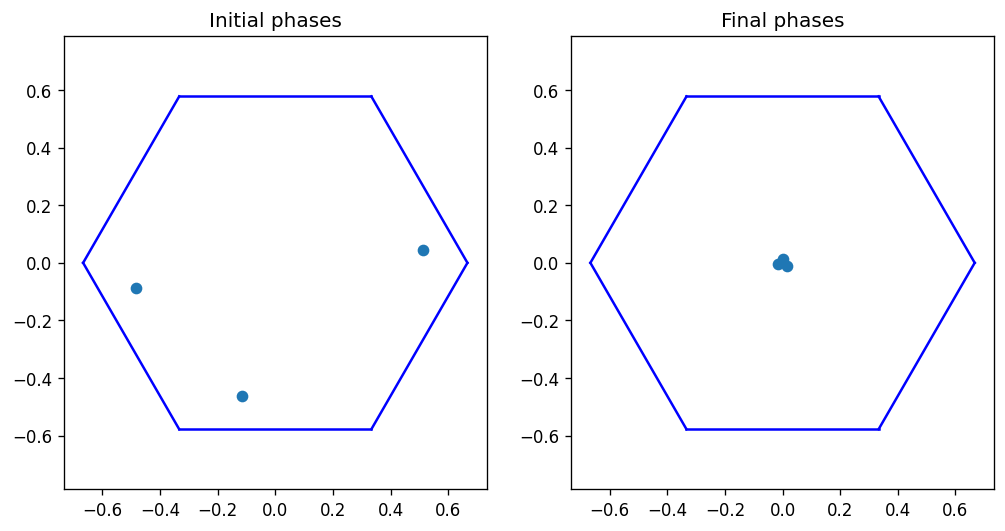

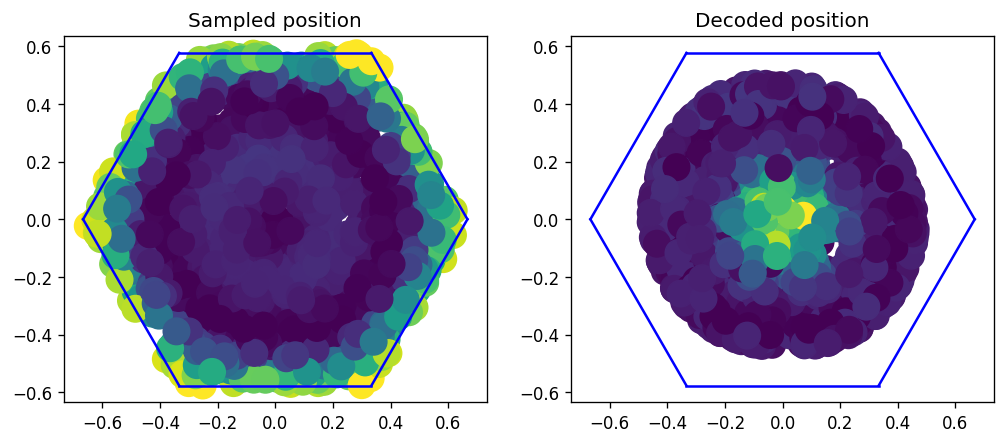

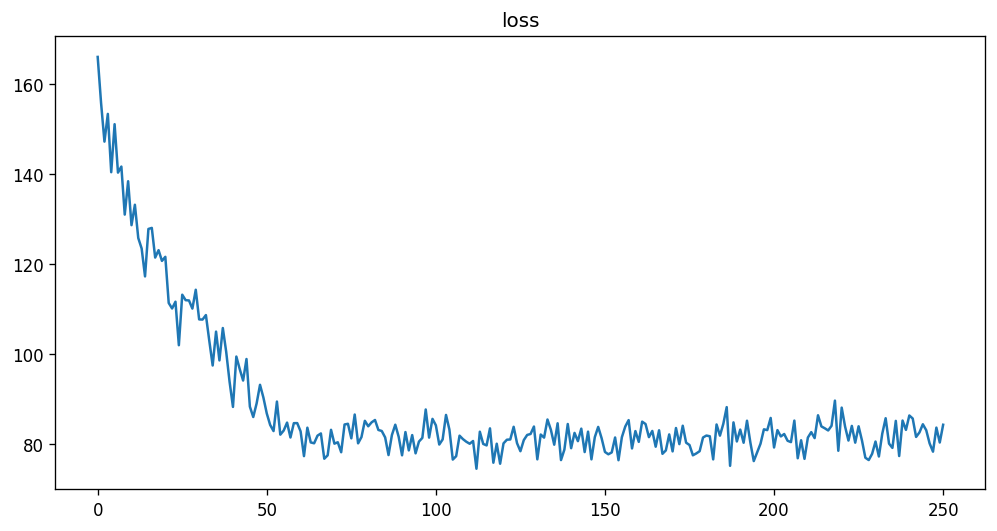


Num pos 1000
Num neurons 5

min=77.27 and mincurr=77.27
min=76.13 and mincurr=76.13
min=74.40 and mincurr=74.40
min=74.40 and mincurr=74.89
min=74.40 and mincurr=75.92
Training finished.
128.9745635986328
74.39675903320312


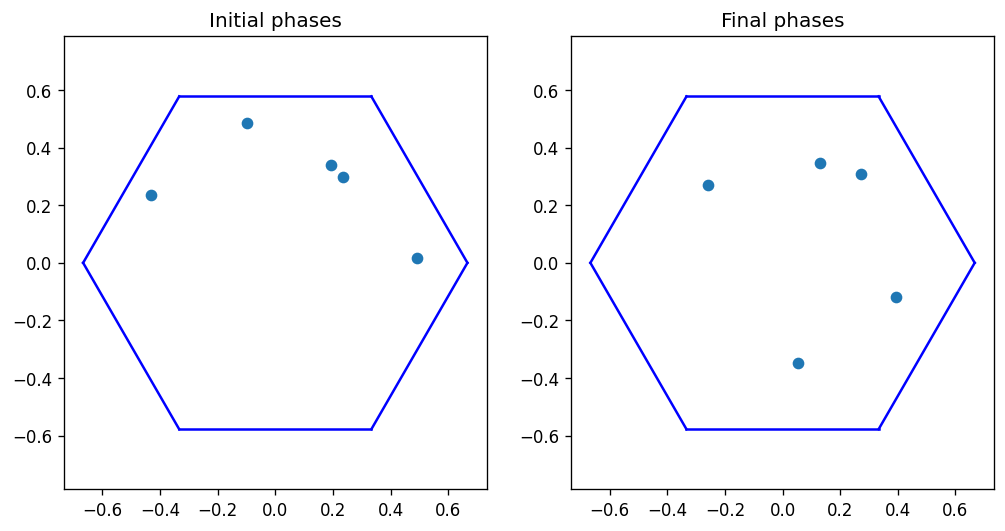

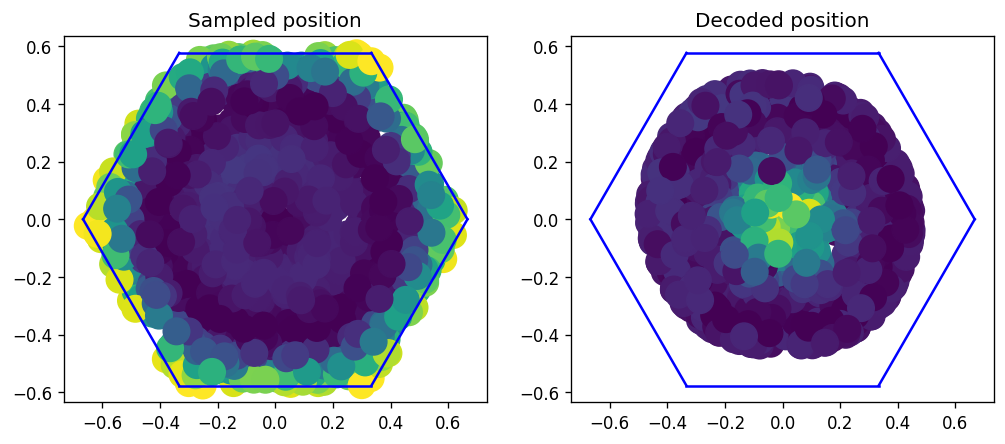

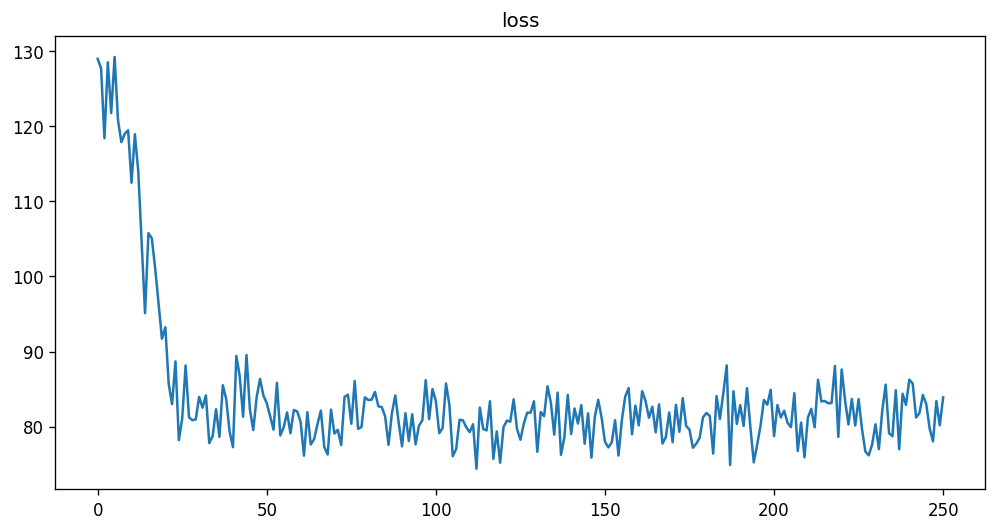


Num pos 1000
Num neurons 10

min=72.46 and mincurr=72.46
min=72.46 and mincurr=75.70
min=72.46 and mincurr=74.09
min=72.46 and mincurr=74.71
min=72.46 and mincurr=75.64
Early stopping at iteration 250
Training finished.
82.92782592773438
72.4640884399414


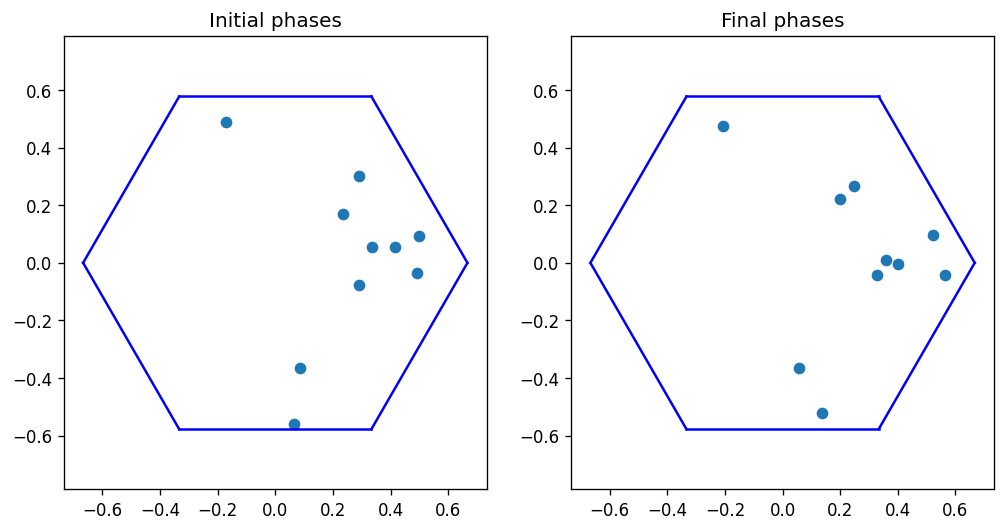

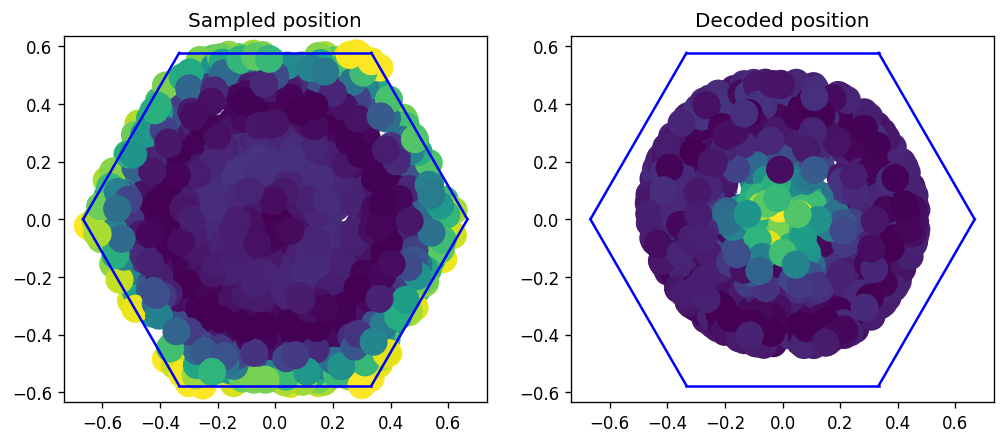

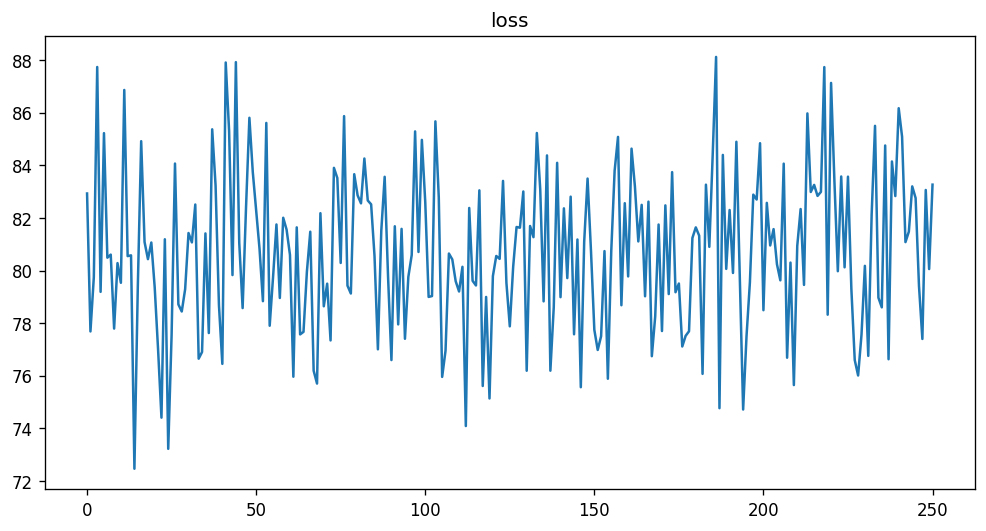


Num pos 1000
Num neurons 50

min=72.46 and mincurr=72.46
min=72.46 and mincurr=75.70
min=72.46 and mincurr=74.09
min=72.46 and mincurr=74.71
min=72.46 and mincurr=75.64
Early stopping at iteration 250
Training finished.
82.92782592773438
72.4640884399414


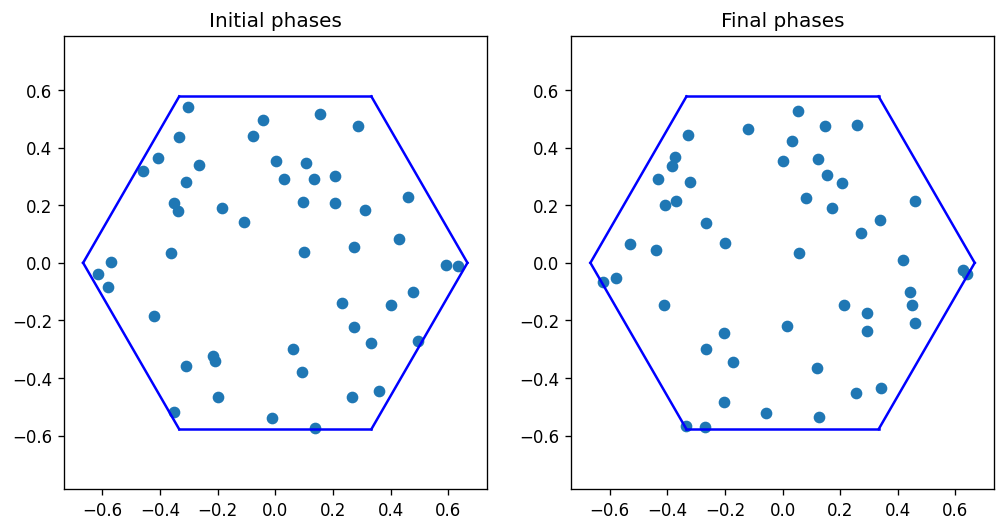

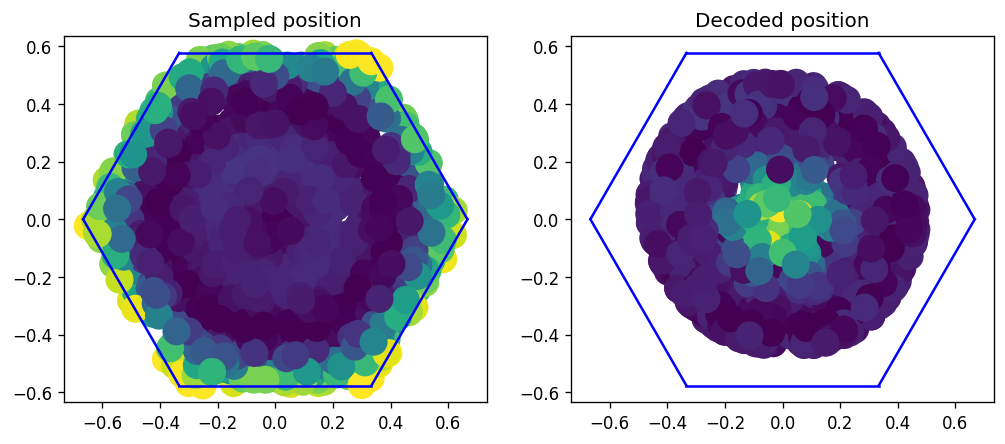

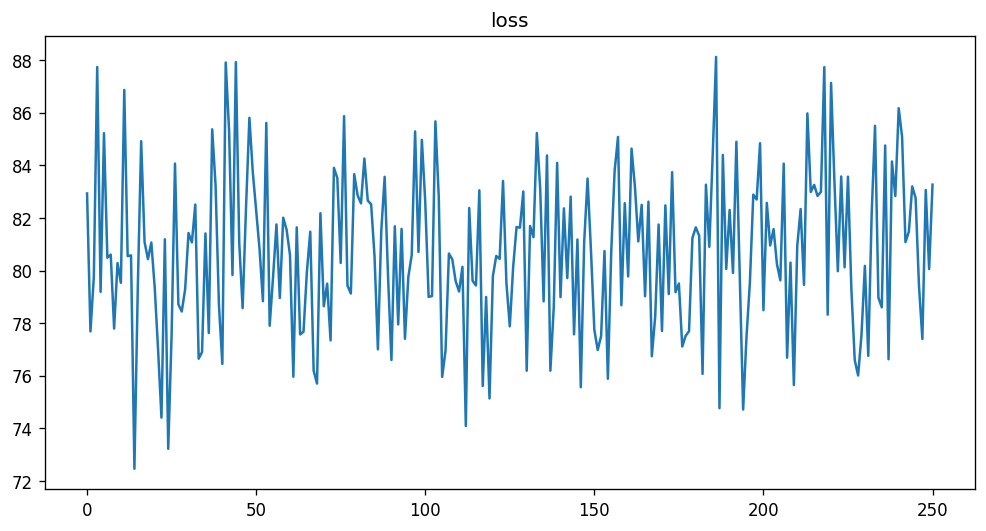


Num pos 1000
Num neurons 200

min=72.46 and mincurr=72.46
min=72.46 and mincurr=75.70
min=72.46 and mincurr=74.09
min=72.46 and mincurr=74.71
min=72.46 and mincurr=75.64
Early stopping at iteration 250
Training finished.
82.92782592773438
72.4640884399414


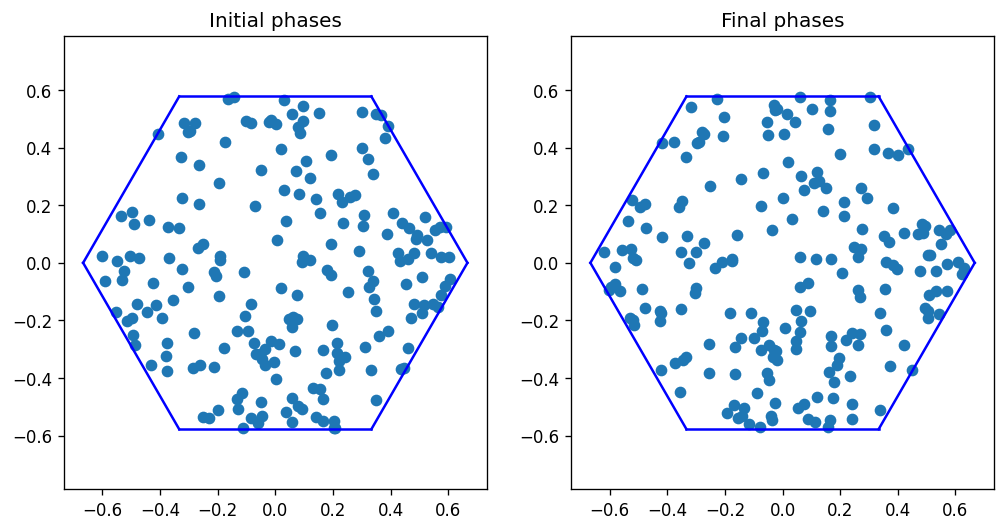

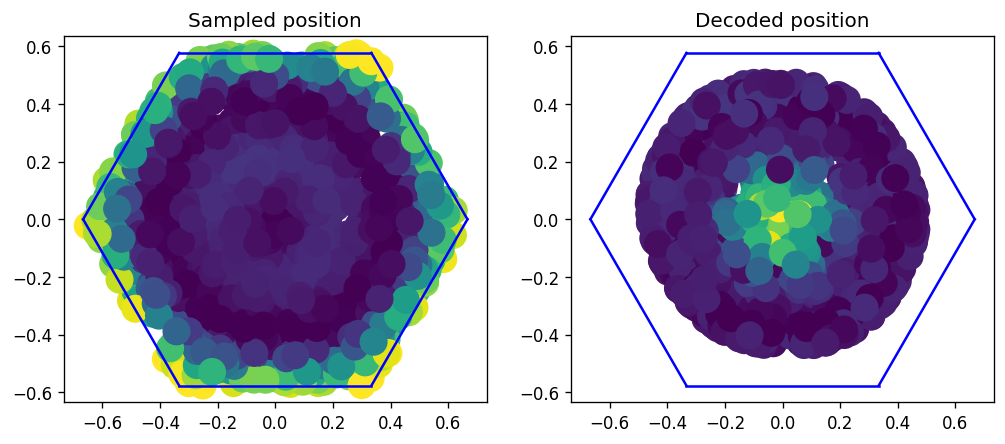

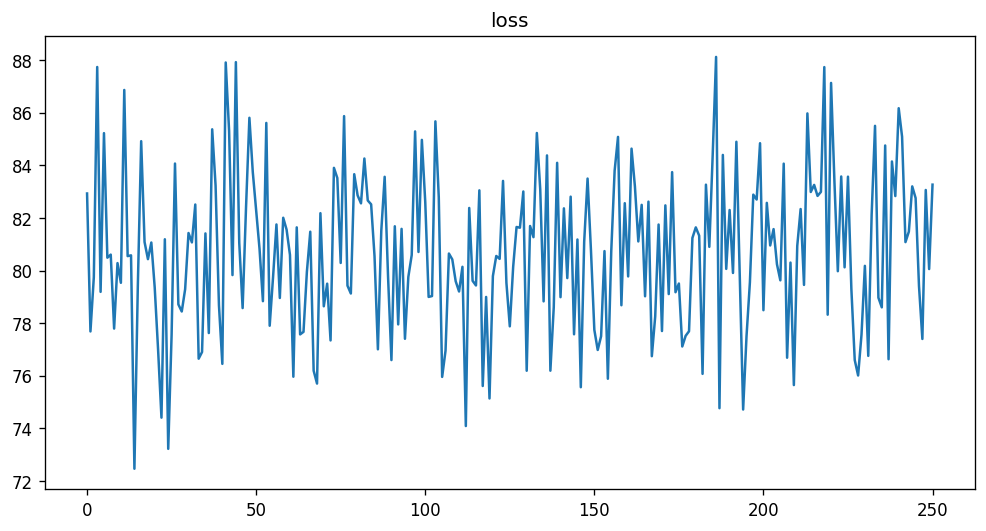

In [3]:
least_squares = True
hex_metric = False
for i, num_pos in enumerate(num_pos_all):
    for j, N in enumerate(N_all):
        print('Num pos', num_pos)
        print('Num neurons', N)
        print('')
        model = LinDecoder(N = N,
                           num_pos = num_pos,
                           hex_metric = hex_metric,
                           least_squares = least_squares,
                    )
        model.train()
        bestphase = np.argmin(model.stats['loss'])
        all_loss[i,j] = model.stats['loss'][bestphase]
        if bVerbose:
            plot_results(model)


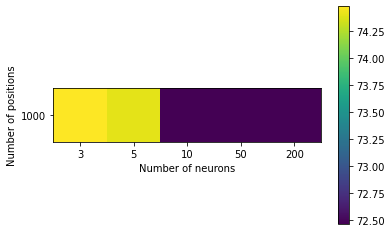

In [4]:
plt.imshow(all_loss)#, origin = 'lower')
plt.yticks(np.arange(len(num_pos_all)), np.array(num_pos_all,dtype = str))
plt.xticks(np.arange(len(N_all)), np.array(N_all,dtype = str))
plt.xlabel('Number of neurons')
plt.ylabel('Number of positions')
plt.colorbar()

## Hexagonal metric lstsqr

Num pos 1000
Num neurons 3



C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['phases'].append(torch.tensor(self.grid_cells.phases))
C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['weights'].append(torch.tensor(self.grid_cells.xyweights))


min=80.39 and mincurr=80.39
min=76.48 and mincurr=76.48
min=75.02 and mincurr=75.02
min=74.91 and mincurr=74.91
min=74.91 and mincurr=76.37
Training finished.
154.2271270751953
74.90593719482422


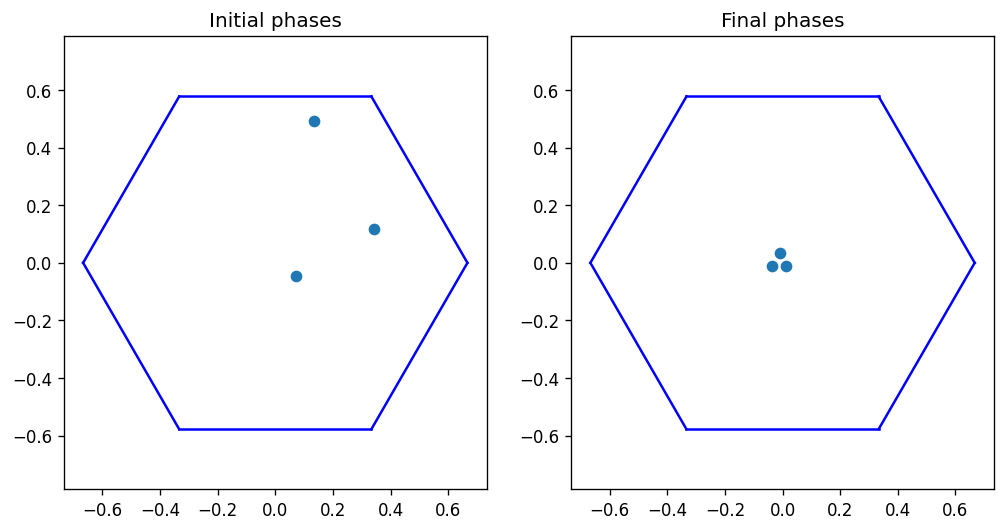

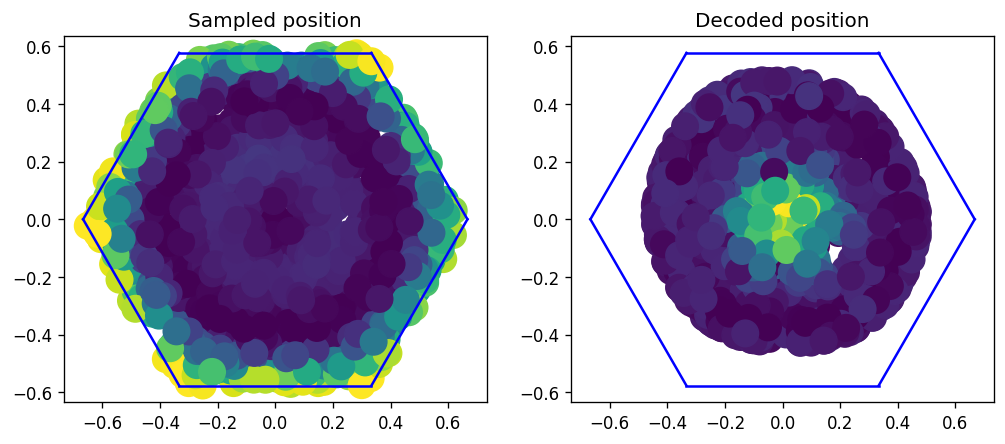

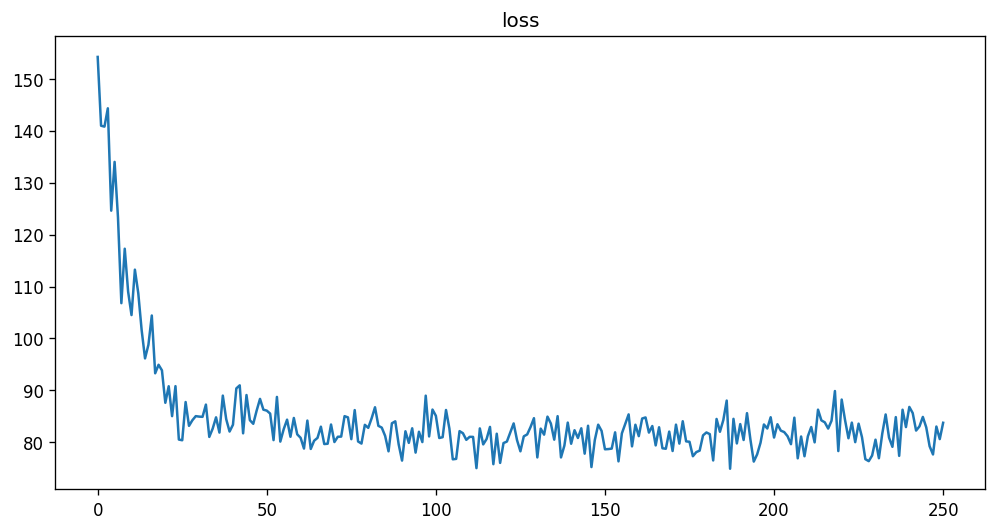


Num pos 1000
Num neurons 5

min=75.91 and mincurr=75.91
min=74.76 and mincurr=74.76
min=74.75 and mincurr=74.75
min=74.75 and mincurr=74.76
min=74.75 and mincurr=75.91
Training finished.
121.75081634521484
74.75497436523438


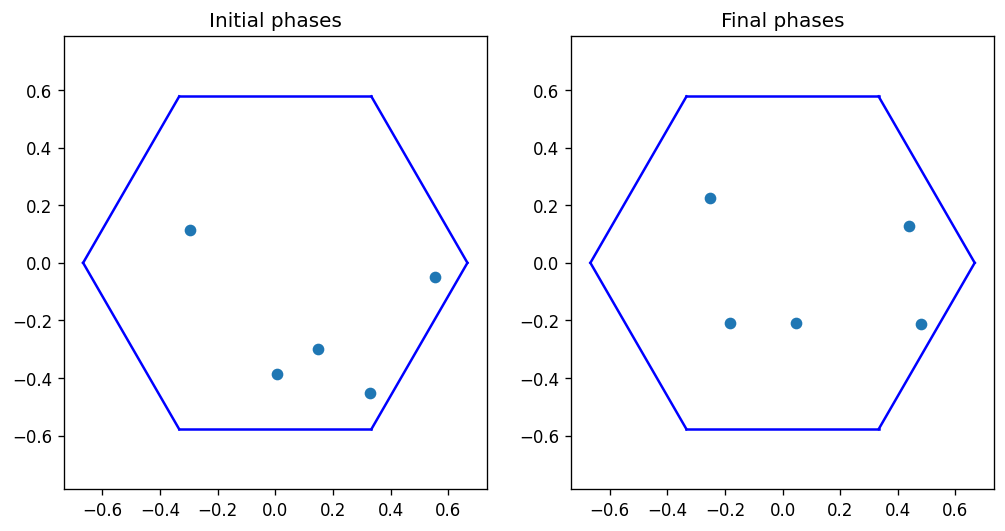

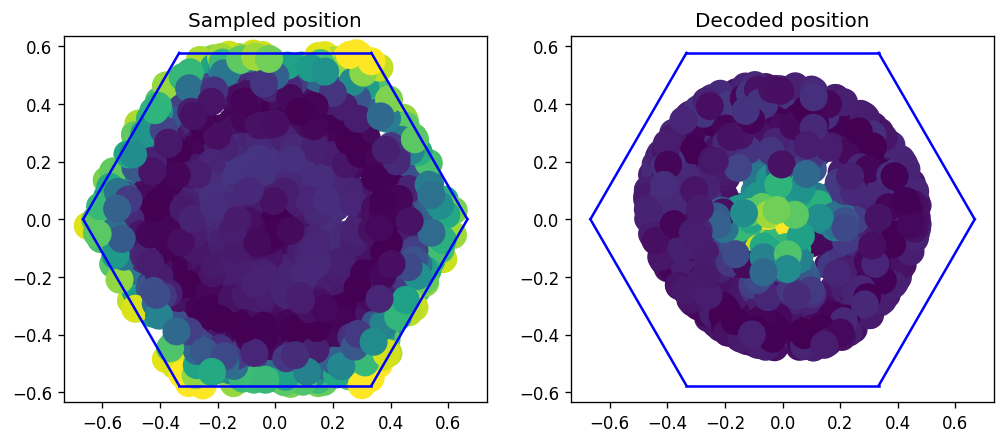

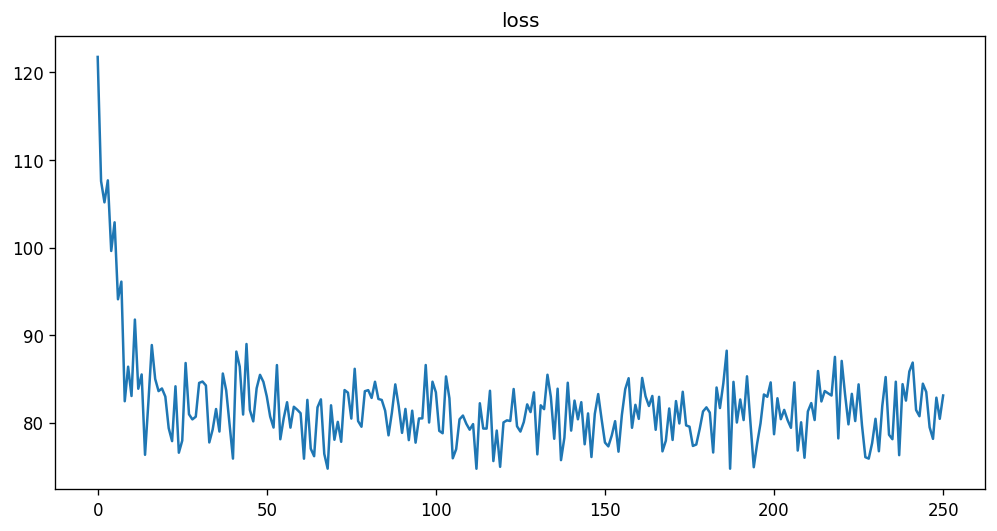


Num pos 1000
Num neurons 10

min=72.28 and mincurr=72.28
min=72.28 and mincurr=74.58
min=72.28 and mincurr=74.00
min=72.28 and mincurr=74.10
min=72.28 and mincurr=75.17
Early stopping at iteration 250
Training finished.
82.32821655273438
72.27605438232422


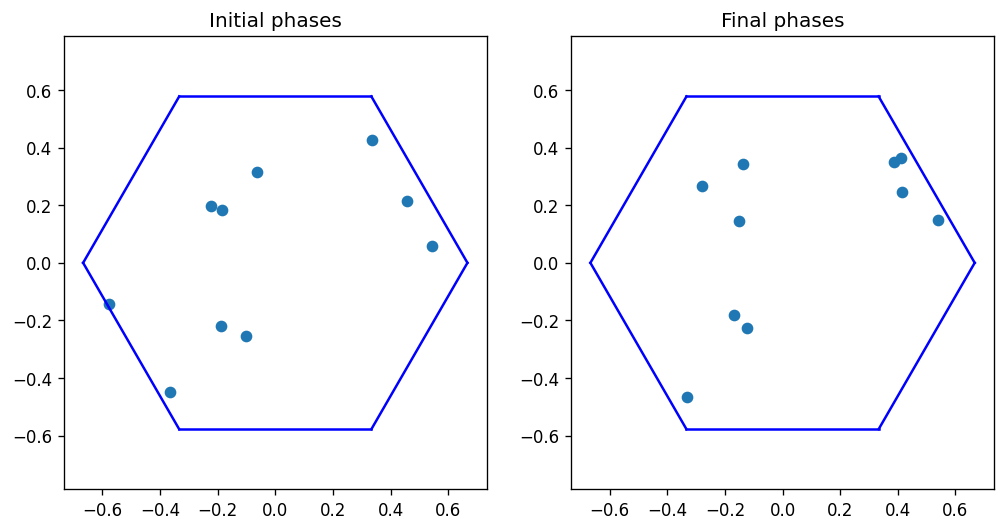

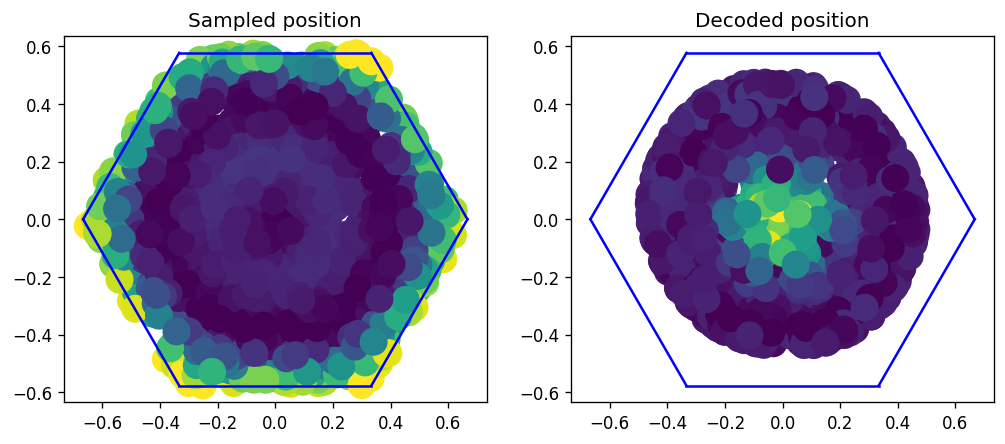

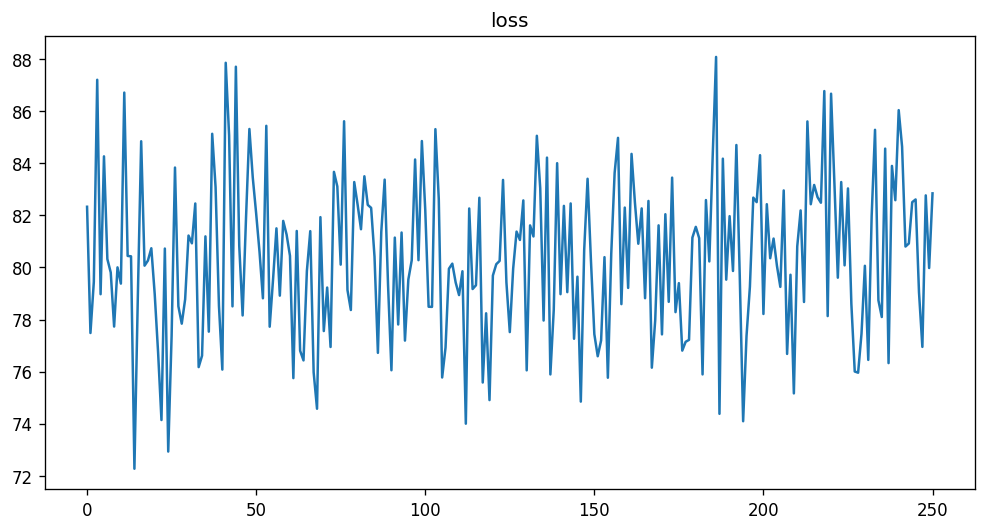


Num pos 1000
Num neurons 50

min=72.28 and mincurr=72.28
min=72.28 and mincurr=74.58
min=72.28 and mincurr=74.00
min=72.28 and mincurr=74.10
min=72.28 and mincurr=75.17
Early stopping at iteration 250
Training finished.
82.32820892333984
72.27605438232422


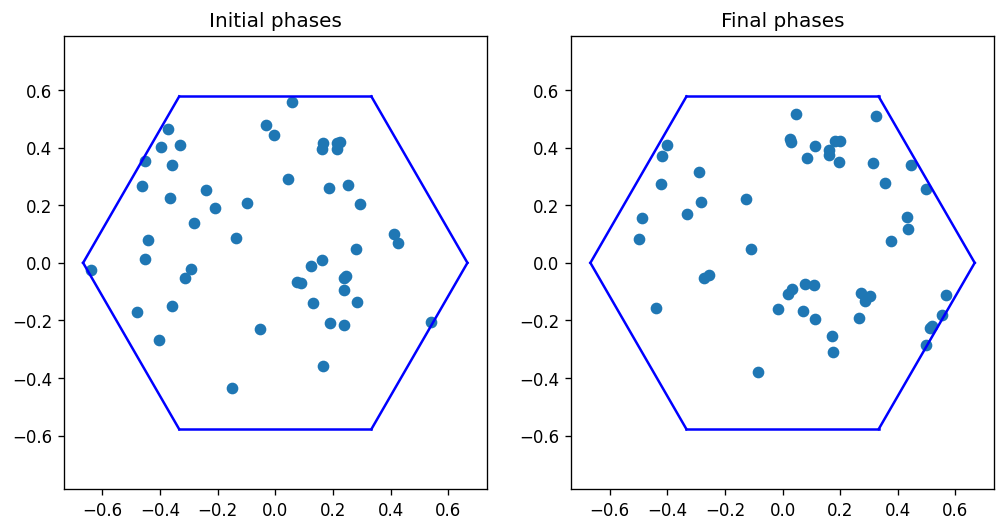

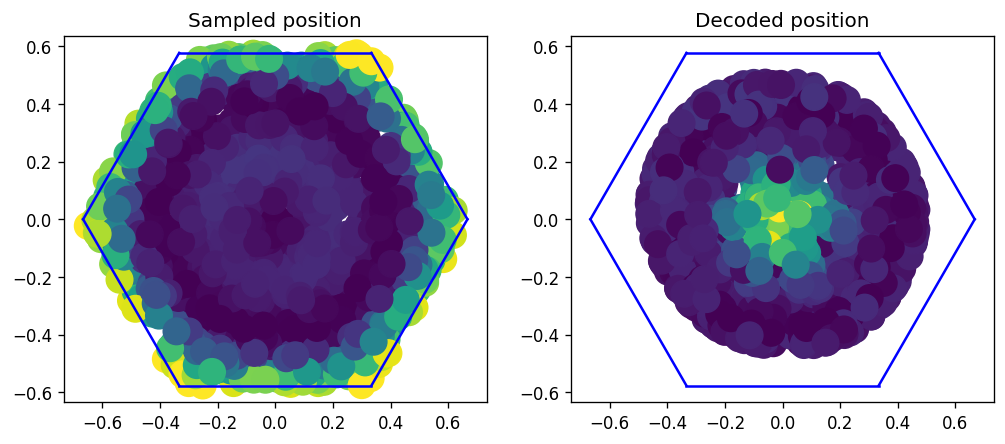

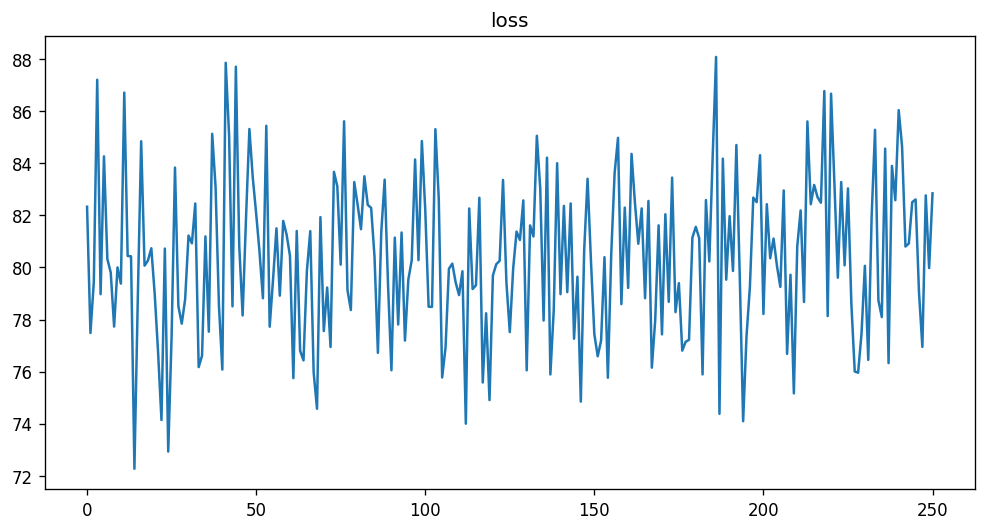


Num pos 1000
Num neurons 200

min=72.28 and mincurr=72.28
min=72.28 and mincurr=74.58
min=72.28 and mincurr=74.00
min=72.28 and mincurr=74.10
min=72.28 and mincurr=75.17
Early stopping at iteration 250
Training finished.
82.32821655273438
72.27604675292969


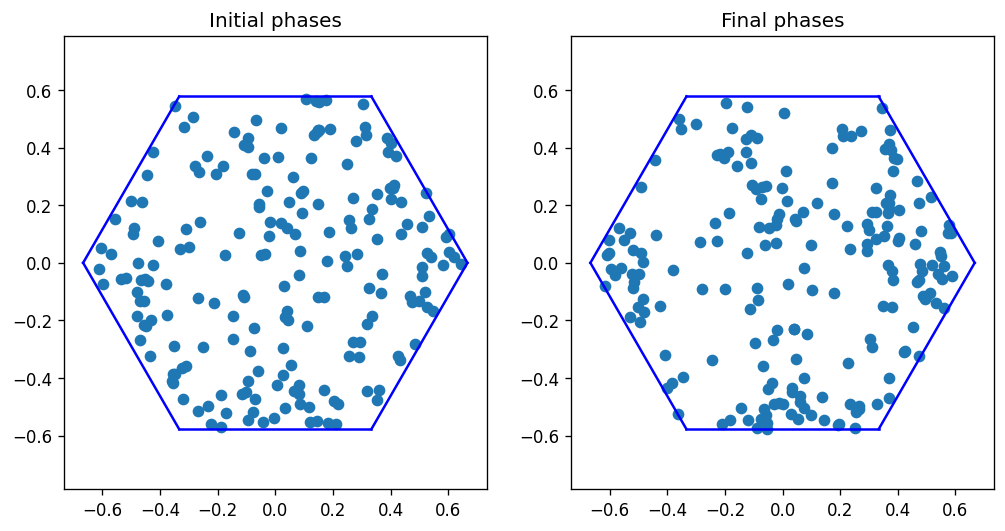

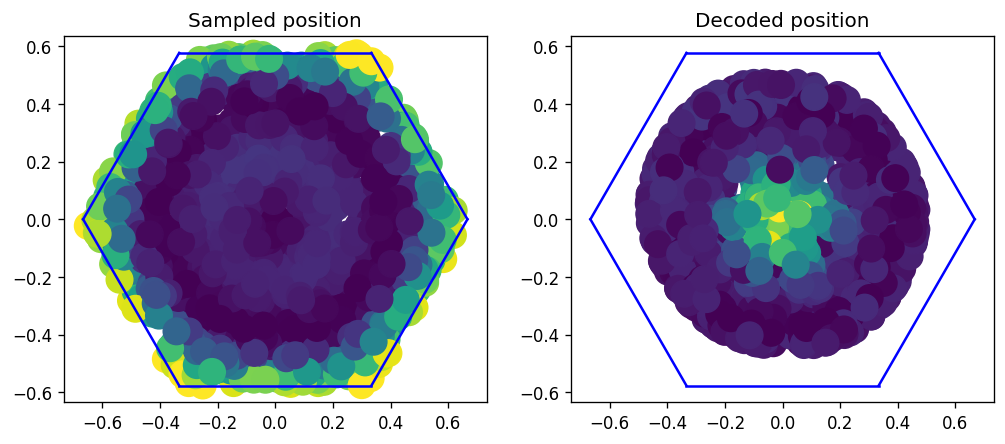

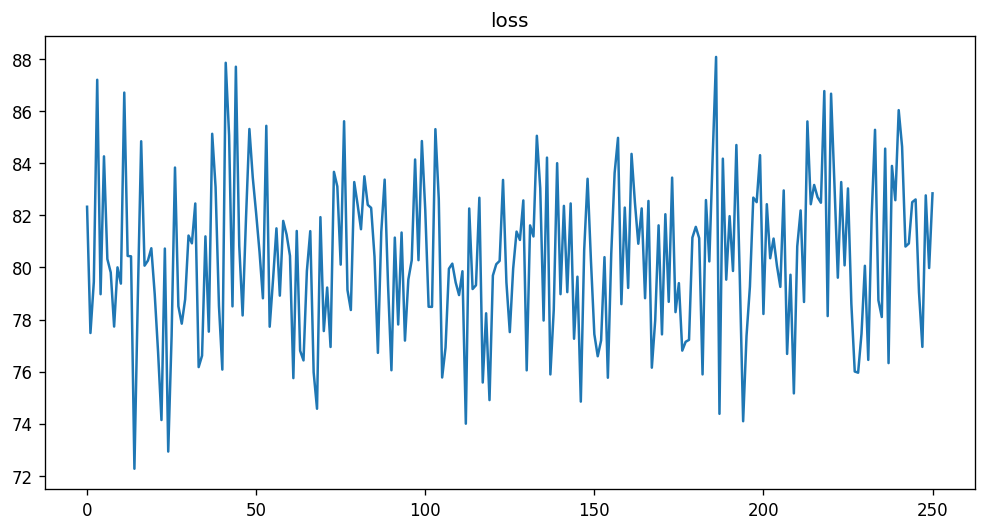

In [5]:
least_squares = True
hex_metric = True
for i, num_pos in enumerate(num_pos_all):
    for j, N in enumerate(N_all):
        print('Num pos', num_pos)
        print('Num neurons', N)
        print('')
        model = LinDecoder(N = N,
                           num_pos = num_pos,
                           hex_metric = hex_metric,
                           least_squares = least_squares,
                           unit_pos = unit_pos,
                           fixed_pos = fixed_pos,
                           verbose = False,
                    )
        model.train()
        bestphase = np.argmin(model.stats['loss'])
        all_loss[i,j] = model.stats['loss'][bestphase]
        if bVerbose:
            plot_results(model)
           


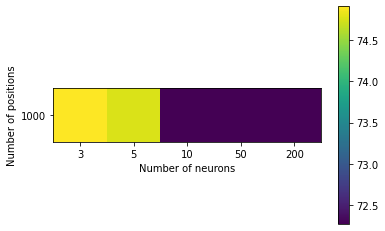

In [6]:
plt.imshow(all_loss)#, origin = 'lower')
plt.yticks(np.arange(len(num_pos_all)), np.array(num_pos_all,dtype = str))
plt.xticks(np.arange(len(N_all)), np.array(N_all,dtype = str))
plt.xlabel('Number of neurons')
plt.ylabel('Number of positions')
plt.colorbar()

## Learn weights

Num pos 1000
Num neurons 3



C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['phases'].append(torch.tensor(self.grid_cells.phases))
C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['weights'].append(torch.tensor(self.grid_cells.xyweights))


min=139.26 and mincurr=139.26
min=103.88 and mincurr=103.88
min=84.35 and mincurr=84.35
min=81.33 and mincurr=81.33
min=81.33 and mincurr=81.60
Training finished.
274.93597412109375
81.3349838256836


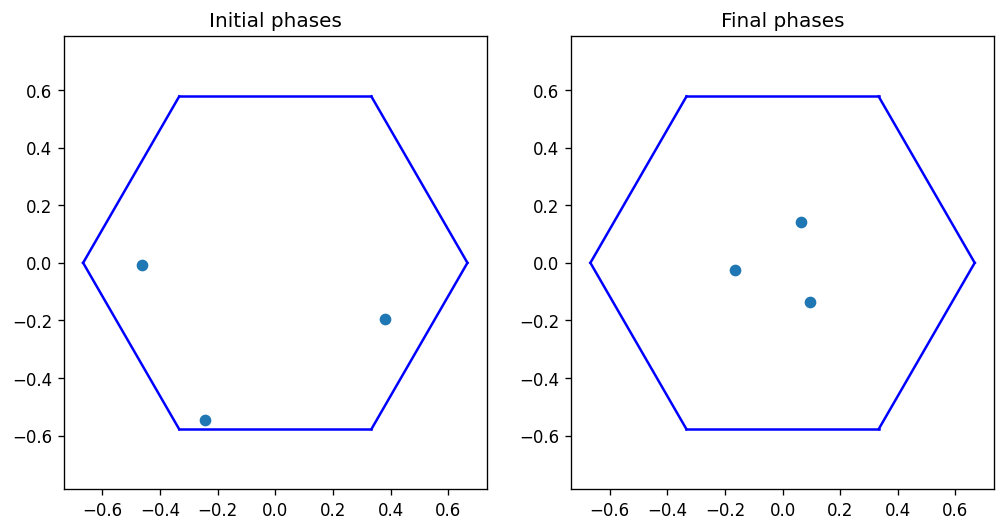

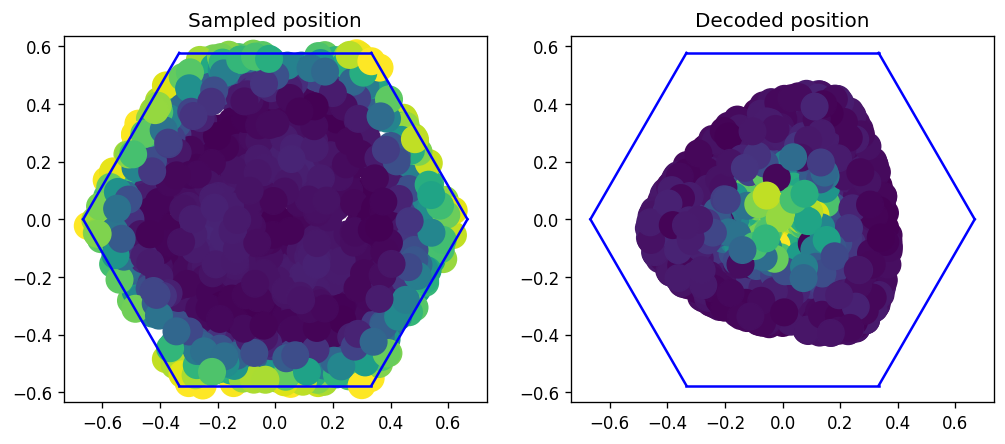

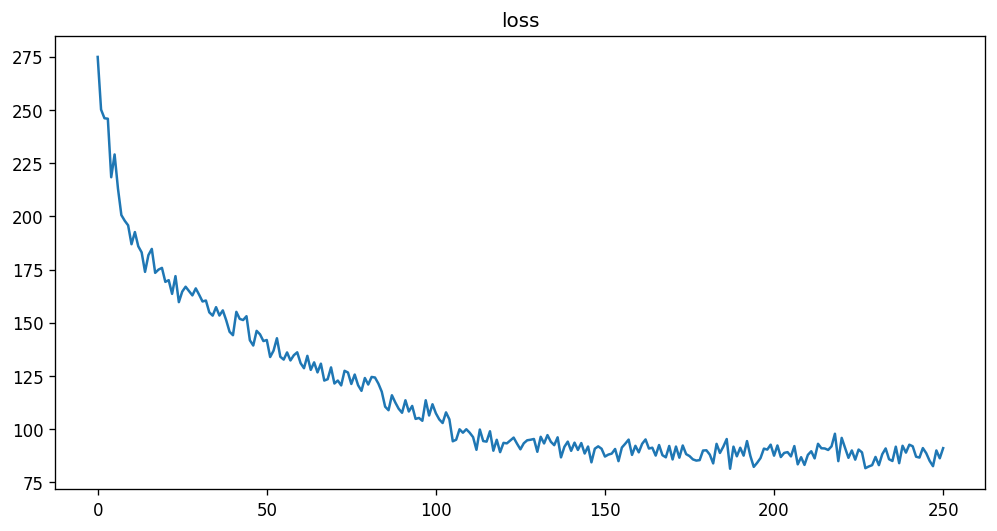


Num pos 1000
Num neurons 5

min=131.88 and mincurr=131.88
min=78.89 and mincurr=78.89
min=74.65 and mincurr=74.65
min=74.65 and mincurr=75.11
min=74.65 and mincurr=76.60
Training finished.
267.24090576171875
74.64788055419922


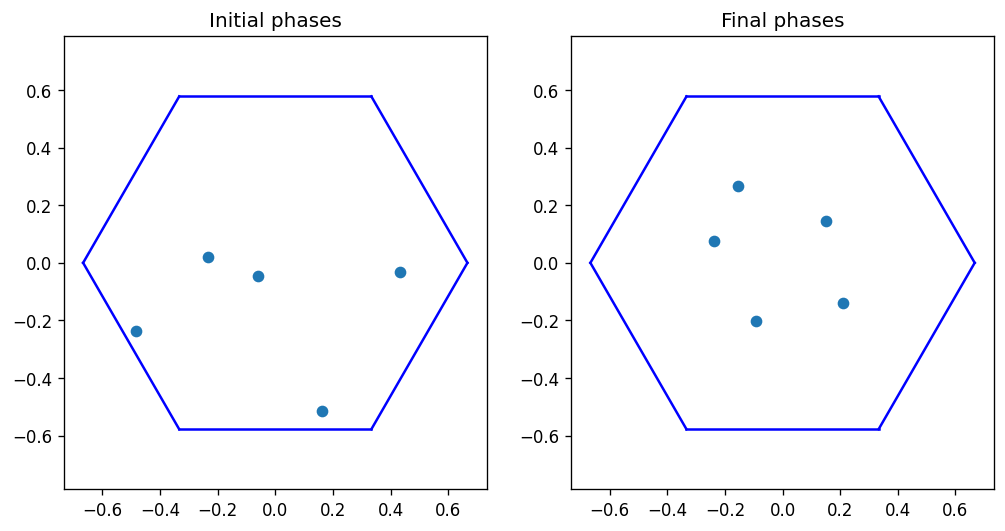

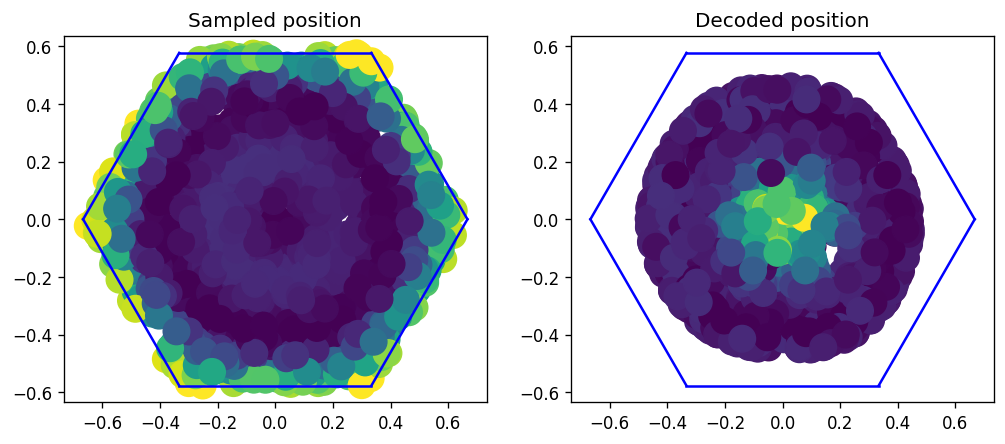

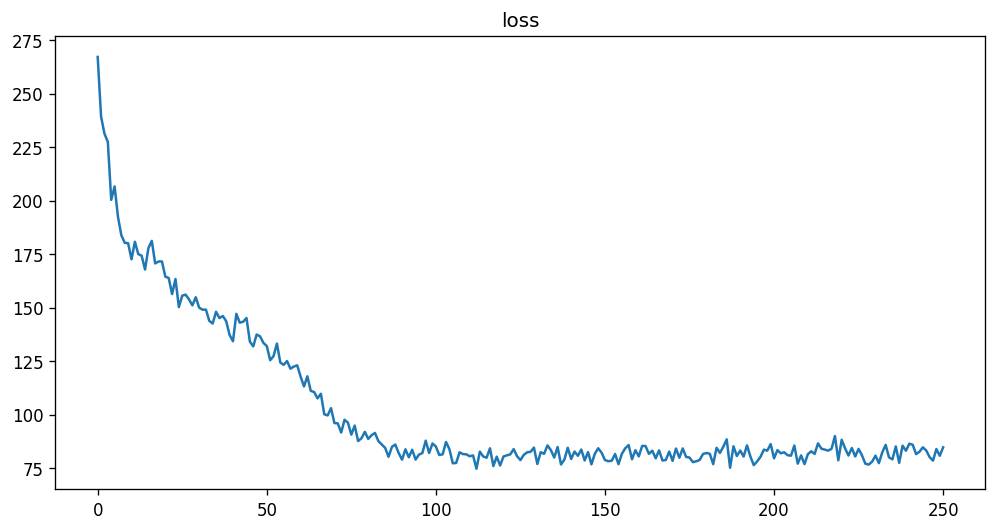


Num pos 1000
Num neurons 10

min=78.54 and mincurr=78.54
min=76.67 and mincurr=76.67
min=74.43 and mincurr=74.43
min=74.43 and mincurr=75.35
min=74.43 and mincurr=76.73
Training finished.
254.23406982421875
74.42575073242188


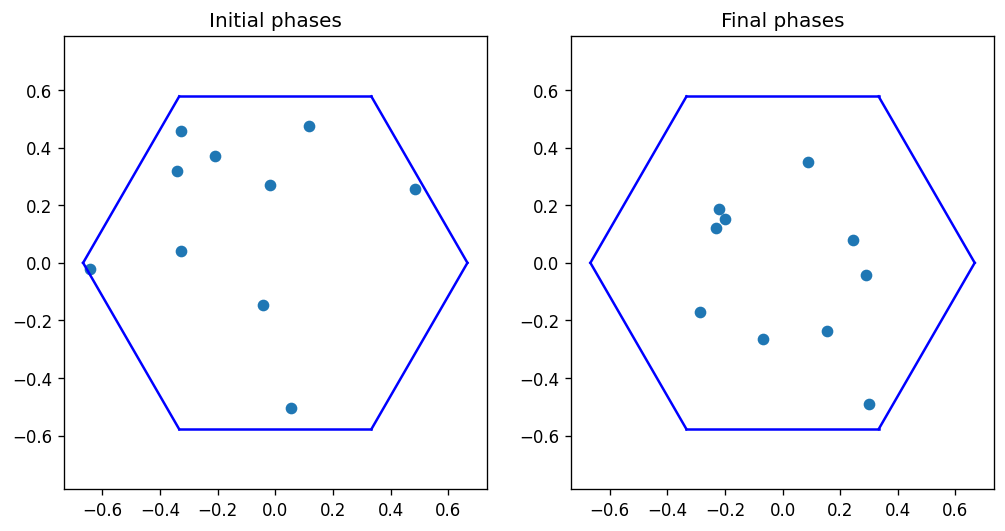

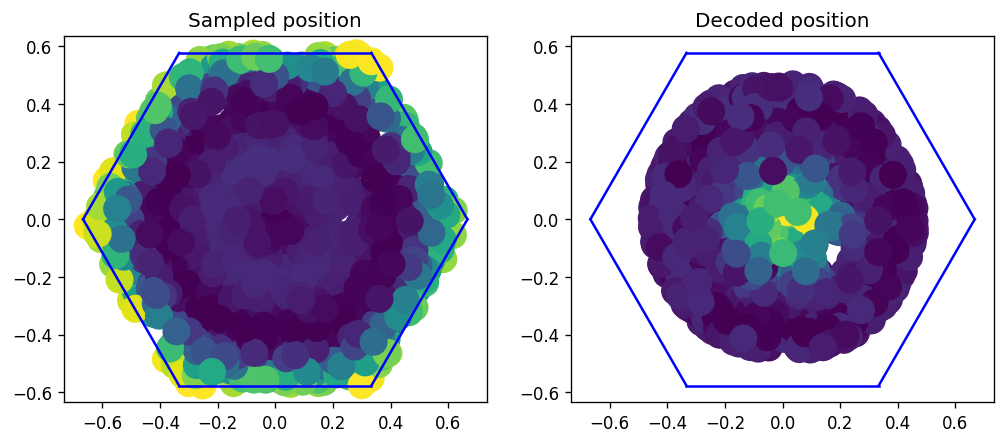

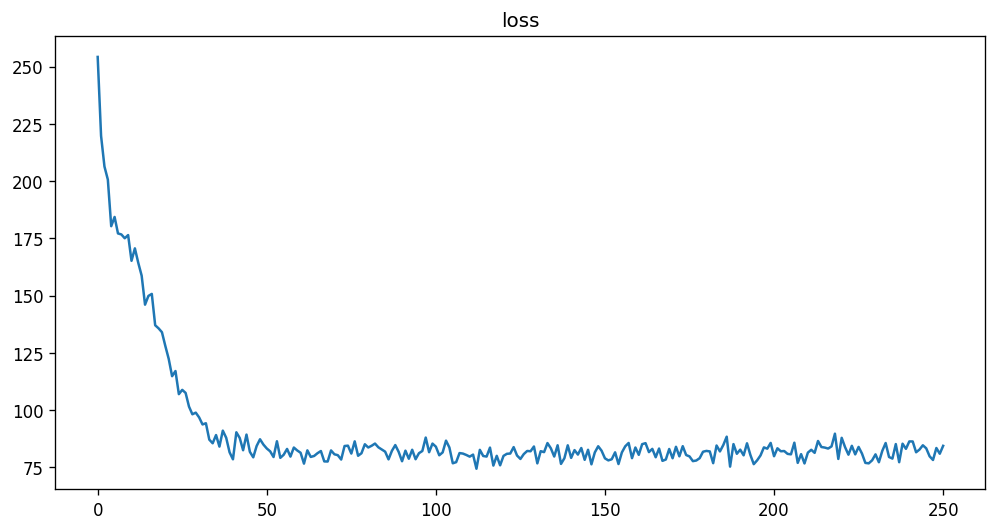


Num pos 1000
Num neurons 50

min=74.62 and mincurr=74.62
min=74.62 and mincurr=76.61
min=74.62 and mincurr=74.66
min=74.62 and mincurr=75.41
min=74.62 and mincurr=76.47
Early stopping at iteration 250
Training finished.
257.0970764160156
74.6176986694336


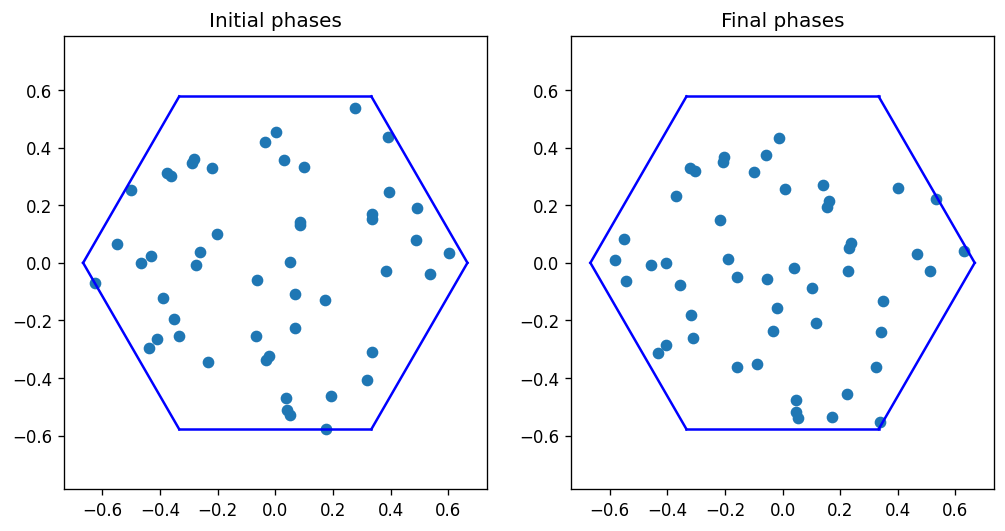

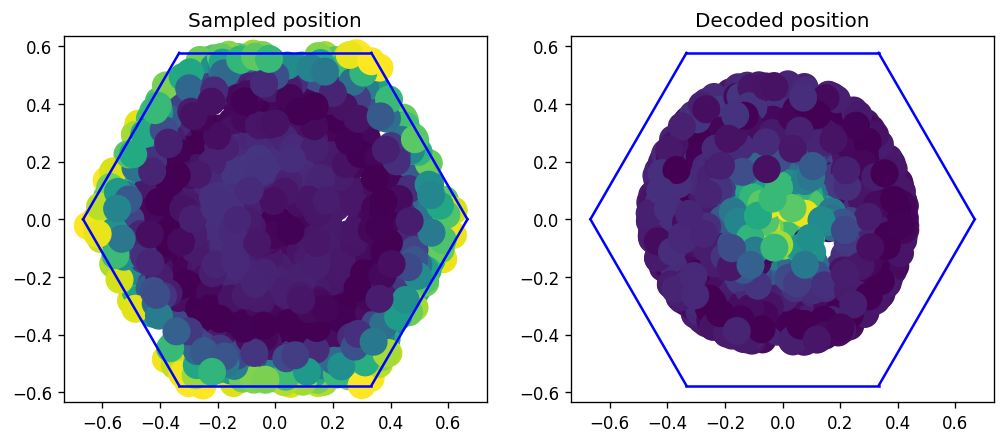

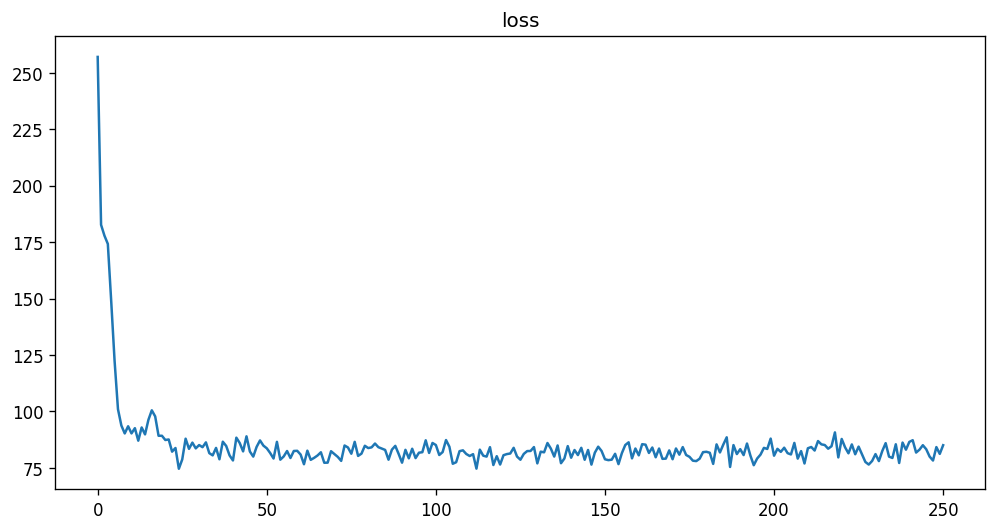


Num pos 1000
Num neurons 200

min=79.75 and mincurr=79.75
min=76.22 and mincurr=76.22
min=75.22 and mincurr=75.22
min=75.22 and mincurr=75.52
min=75.22 and mincurr=77.12
Training finished.
249.24134826660156
75.21935272216797


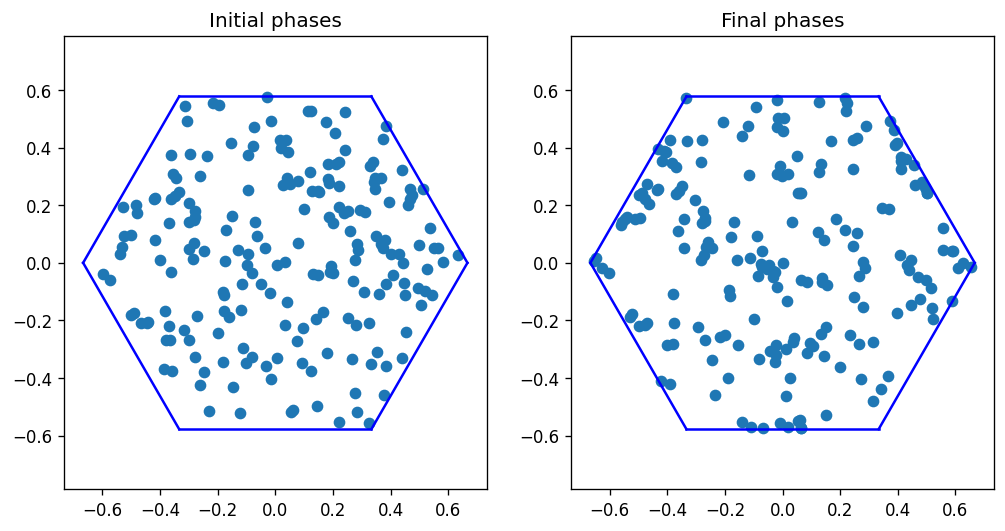

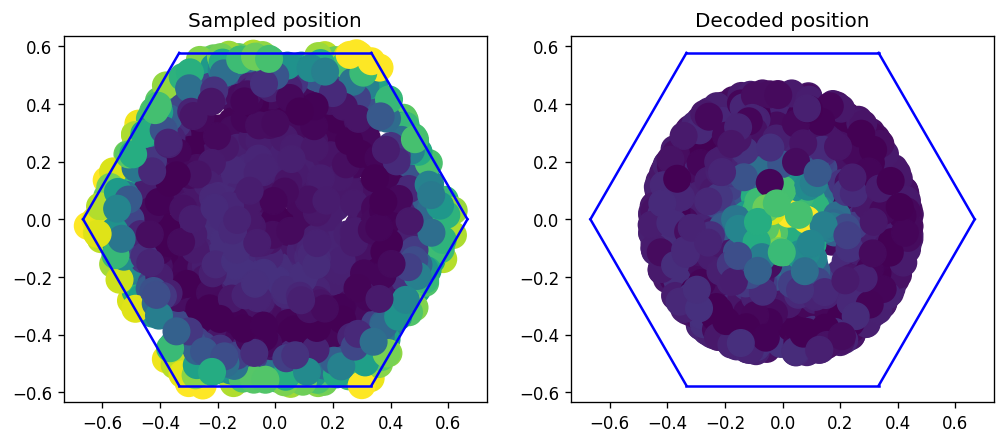

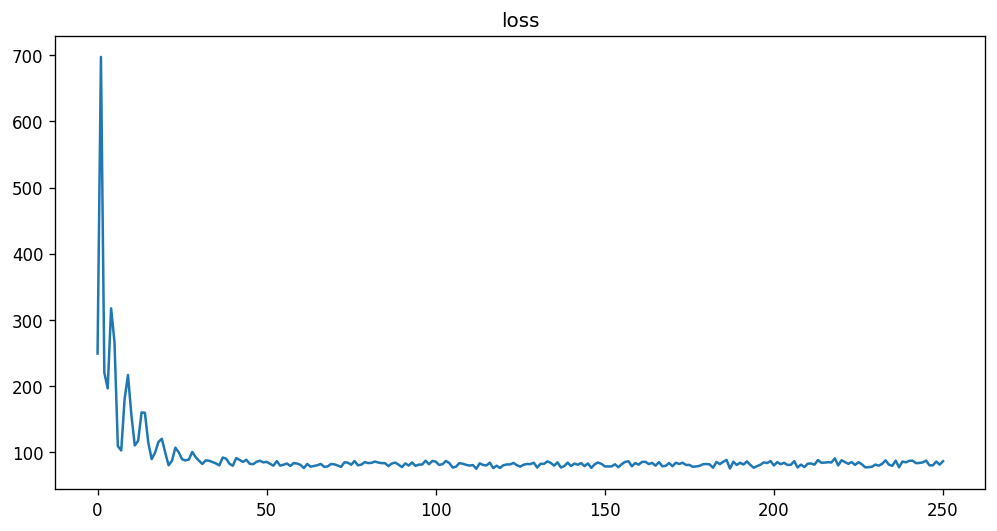

In [7]:
least_squares = False
hex_metric = False
for i, num_pos in enumerate(num_pos_all):
    for j, N in enumerate(N_all):
        print('Num pos', num_pos)
        print('Num neurons', N)
        print('')
        model = LinDecoder(N = N,
                           num_pos = num_pos,
                           hex_metric = hex_metric,
                           least_squares = least_squares,
                    )
        model.train()
        bestphase = np.argmin(model.stats['loss'])
        all_loss[i,j] = model.stats['loss'][bestphase]
        if bVerbose:
            plot_results(model)


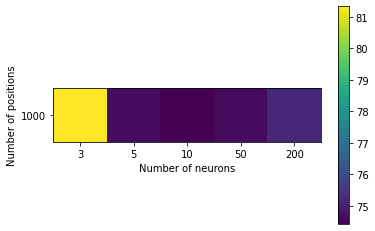

In [8]:
plt.imshow(all_loss)#, origin = 'lower')
plt.yticks(np.arange(len(num_pos_all)), np.array(num_pos_all,dtype = str))
plt.xticks(np.arange(len(N_all)), np.array(N_all,dtype = str))
plt.xlabel('Number of neurons')
plt.ylabel('Number of positions')
plt.colorbar()

## Hexagonal metric learn weights

Num pos 1000
Num neurons 3



C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['phases'].append(torch.tensor(self.grid_cells.phases))
C:\Users\Finnern\AppData\Local\Temp/ipykernel_29384/4176333892.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stats['weights'].append(torch.tensor(self.grid_cells.xyweights))


min=108.29 and mincurr=108.29
min=78.38 and mincurr=78.38
min=77.54 and mincurr=77.54
min=77.54 and mincurr=77.61
min=74.17 and mincurr=74.17
Training finished.
181.5977783203125
74.17082214355469


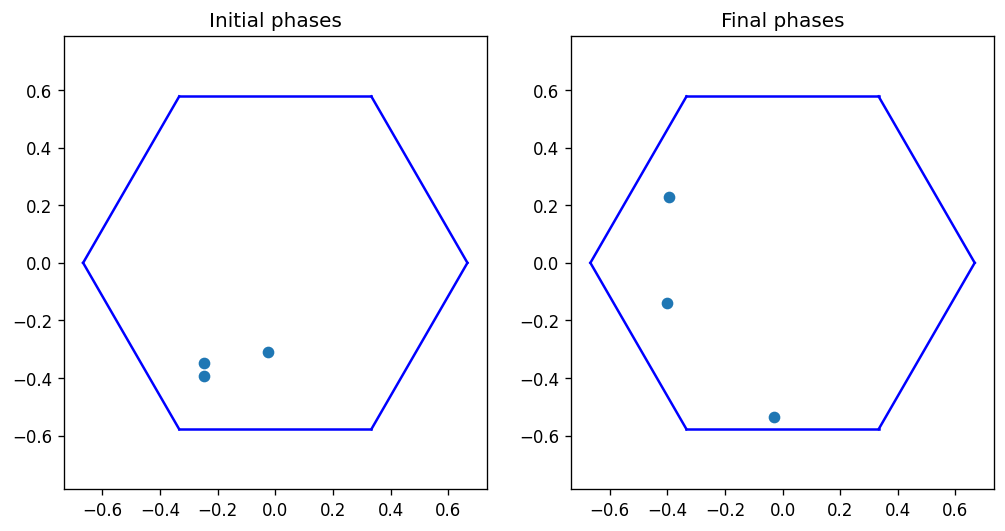

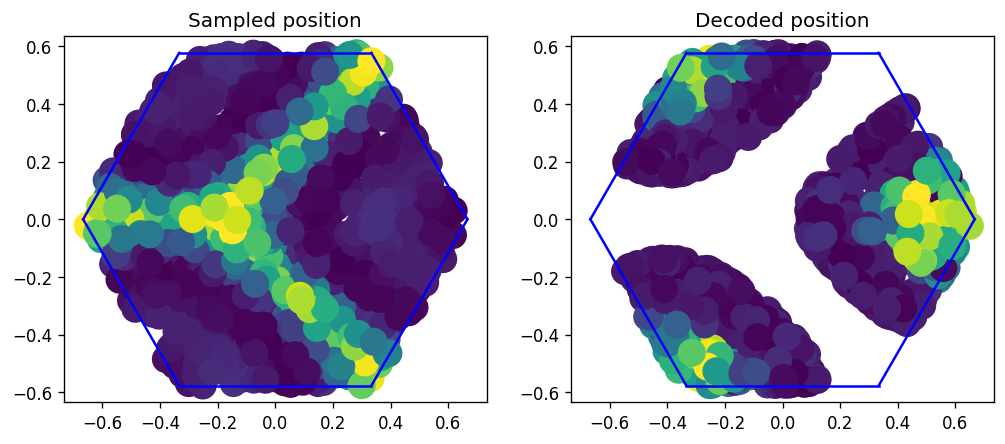

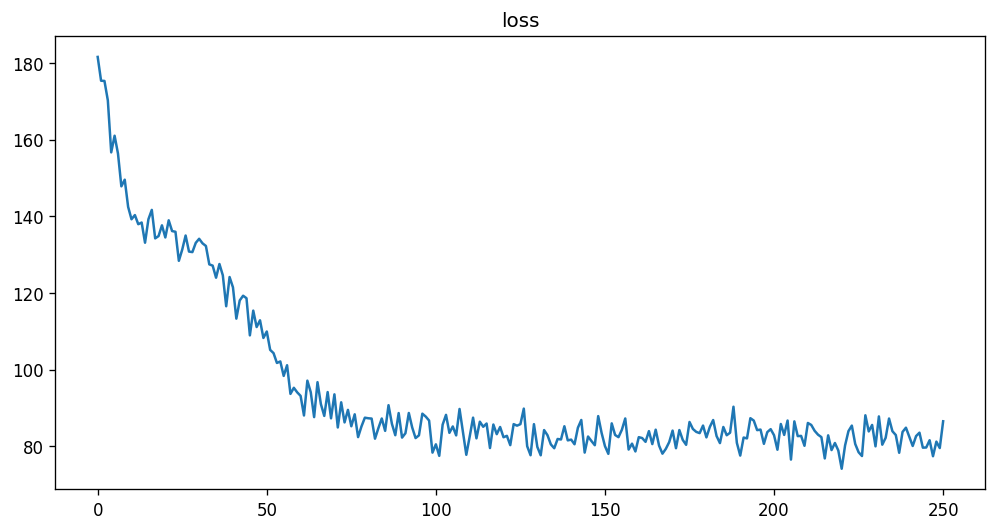


Num pos 1000
Num neurons 5

min=82.41 and mincurr=82.41
min=77.51 and mincurr=77.51
min=73.59 and mincurr=73.59
min=73.59 and mincurr=74.30
min=73.59 and mincurr=74.59
Training finished.
170.26620483398438
73.59098815917969


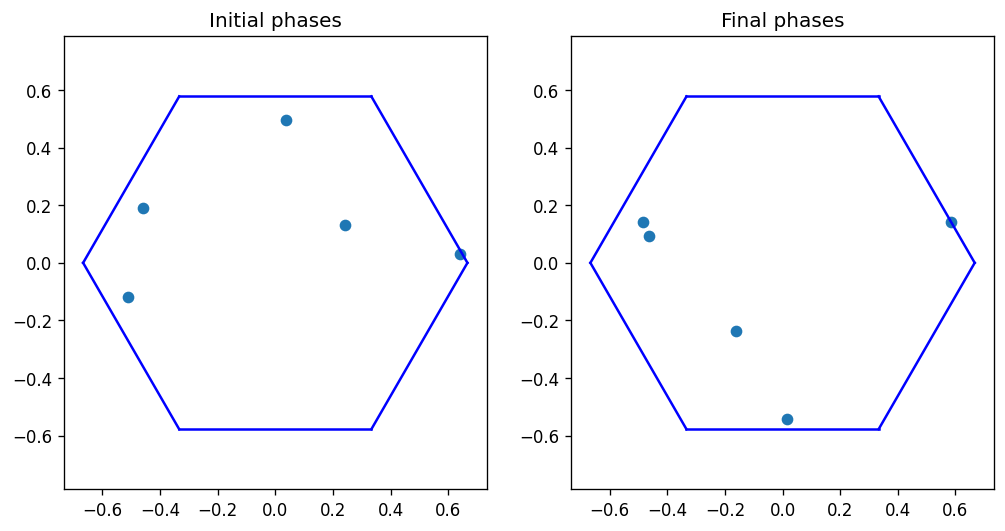

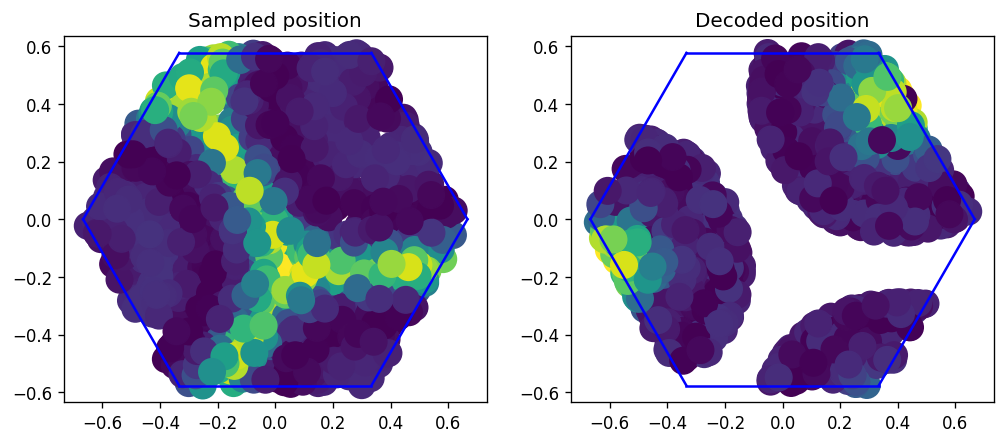

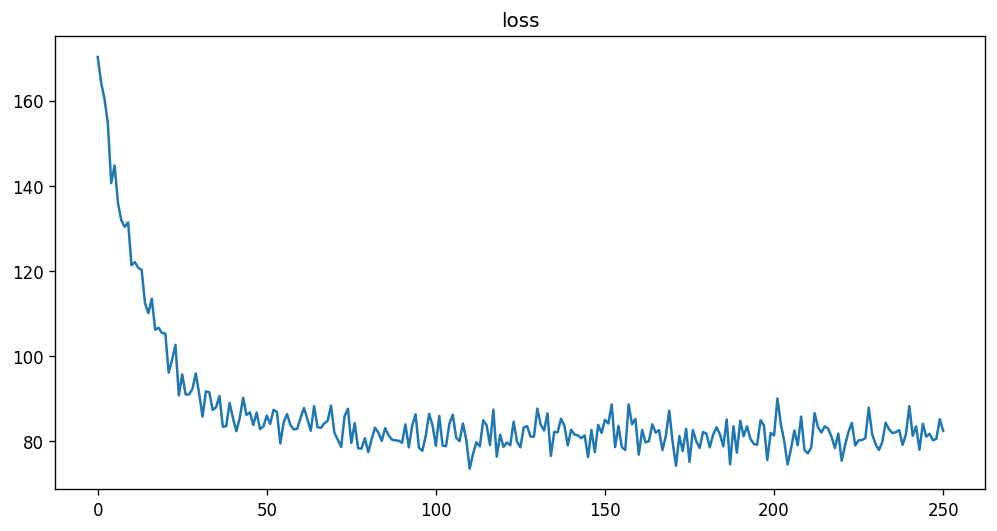


Num pos 1000
Num neurons 10

min=77.12 and mincurr=77.12
min=77.12 and mincurr=78.09
min=76.33 and mincurr=76.33
min=73.96 and mincurr=73.96
min=73.96 and mincurr=75.58
Training finished.
181.50732421875
73.95665740966797


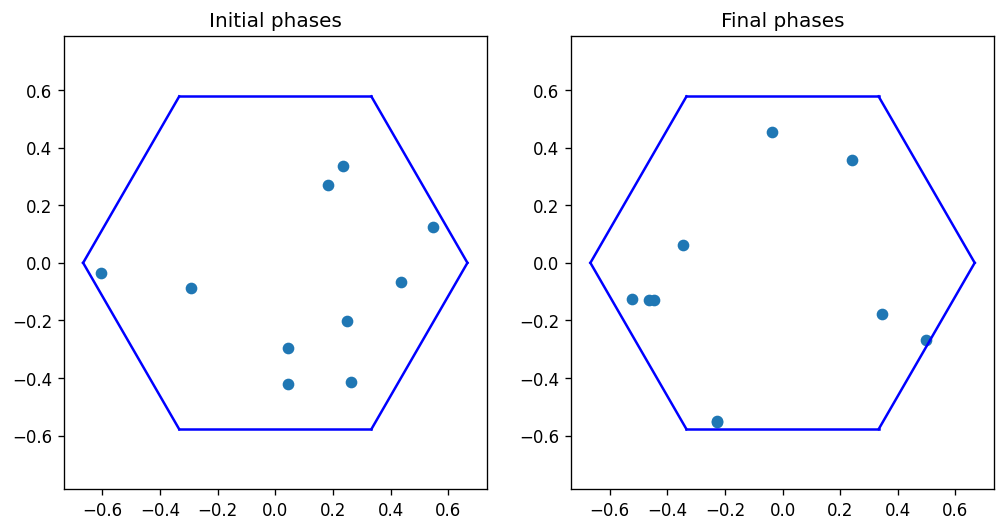

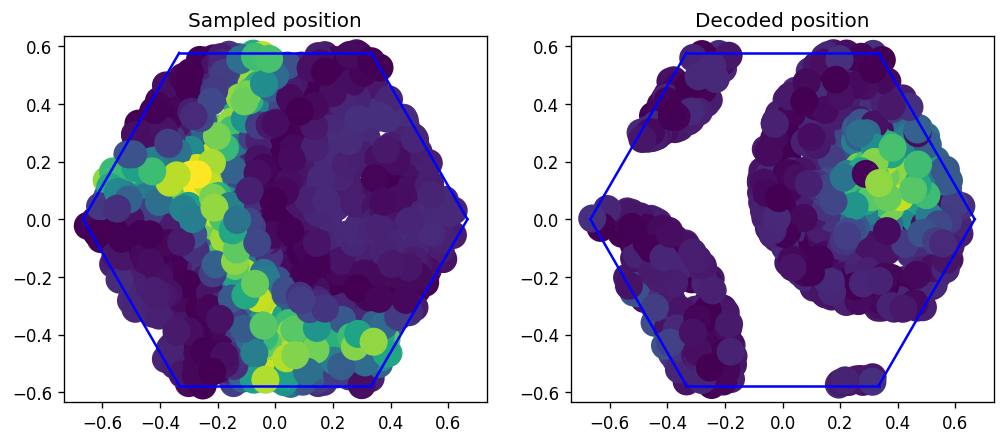

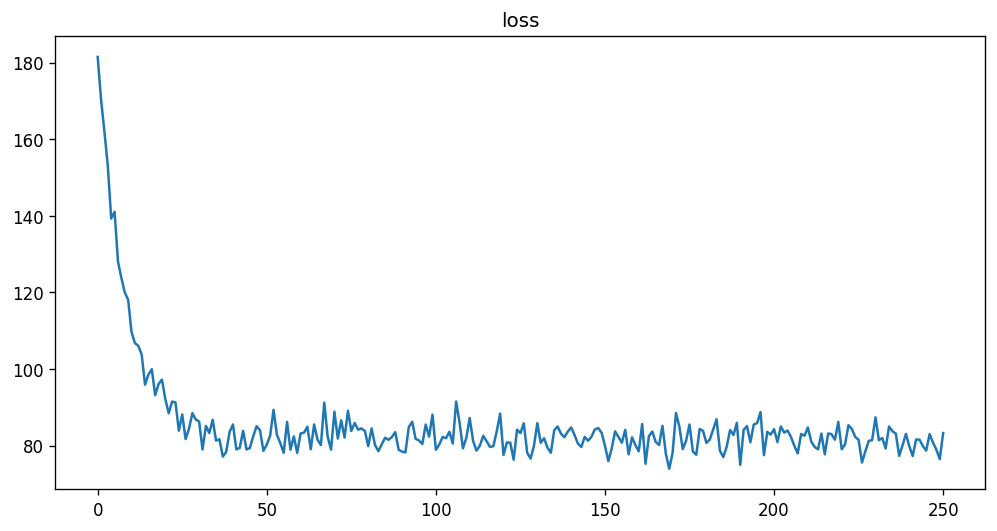


Num pos 1000
Num neurons 50

min=75.02 and mincurr=75.02
min=75.02 and mincurr=75.71
min=75.02 and mincurr=75.12
min=73.48 and mincurr=73.48
min=72.14 and mincurr=72.14
Training finished.
176.83804321289062
72.1391830444336


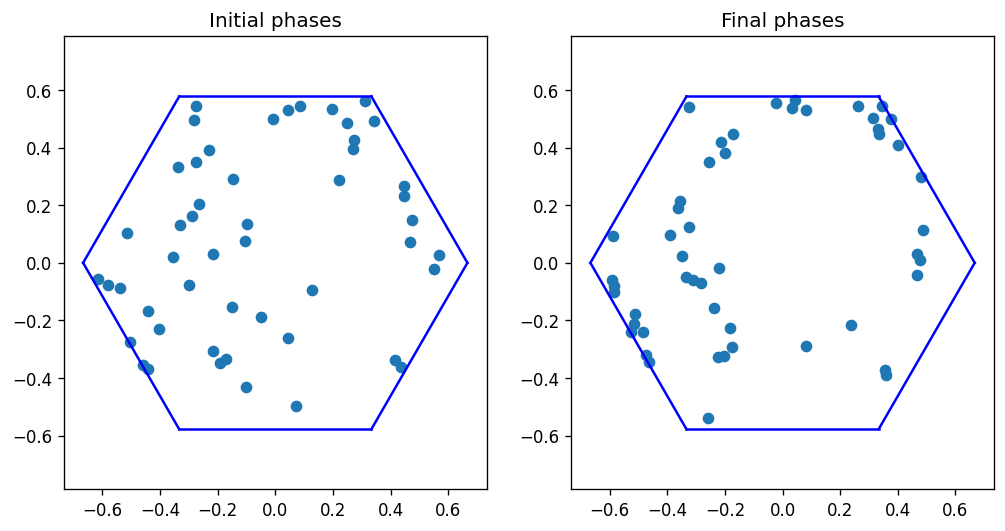

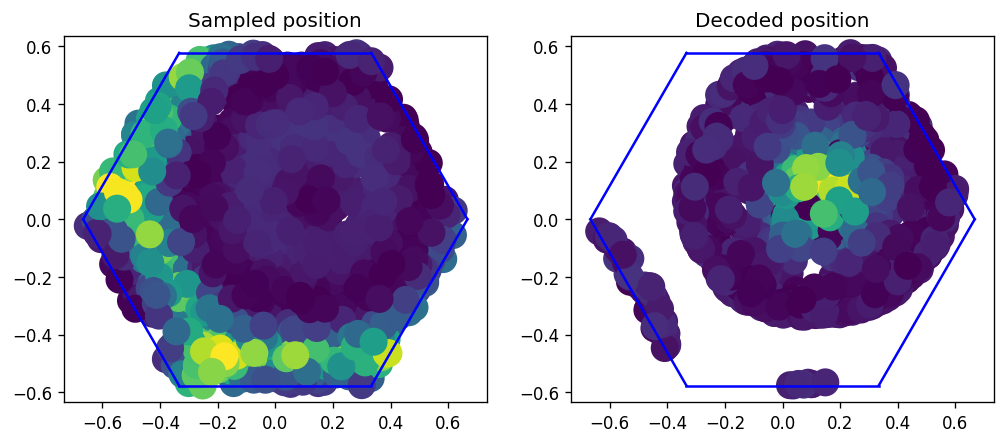

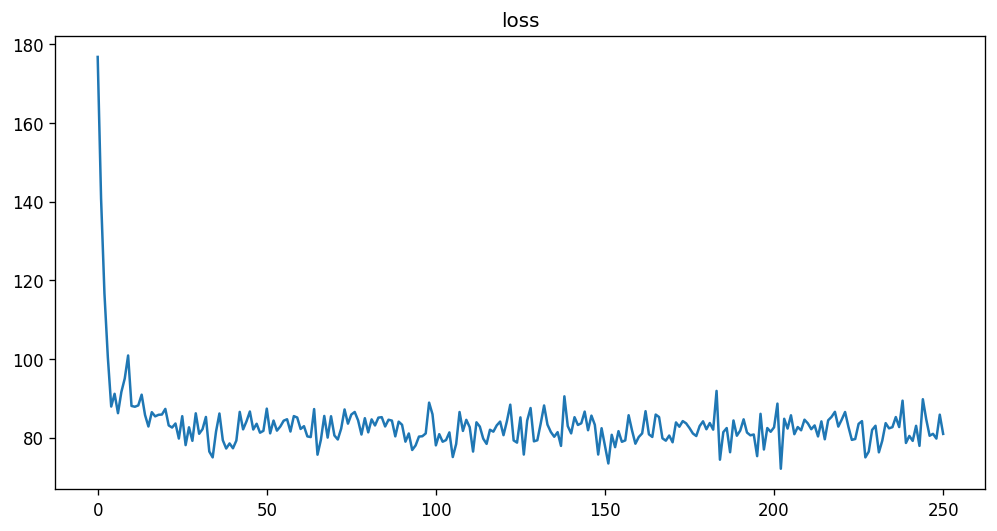


Num pos 1000
Num neurons 200

min=77.52 and mincurr=77.52
min=74.85 and mincurr=74.85
min=74.85 and mincurr=76.22
min=74.85 and mincurr=76.56
min=74.85 and mincurr=77.04
Training finished.
188.4080810546875
74.84797668457031


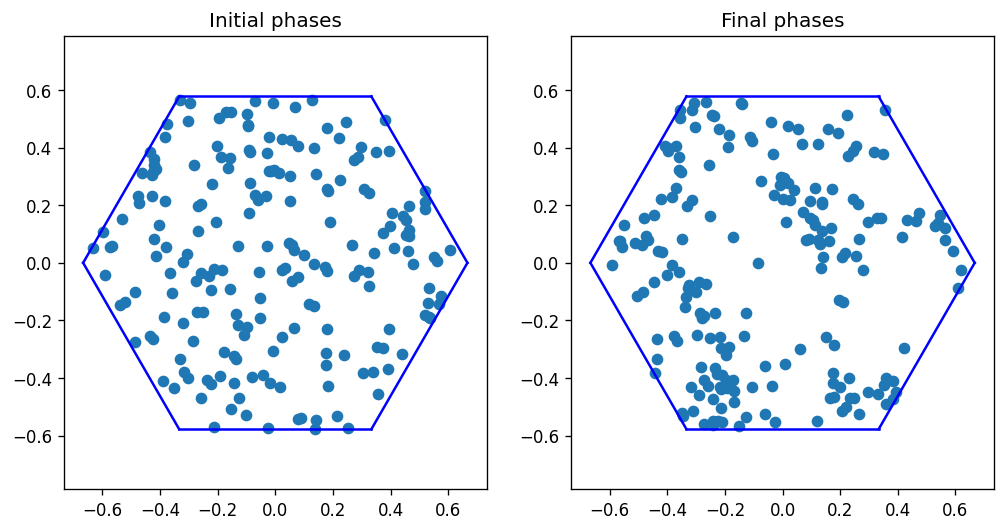

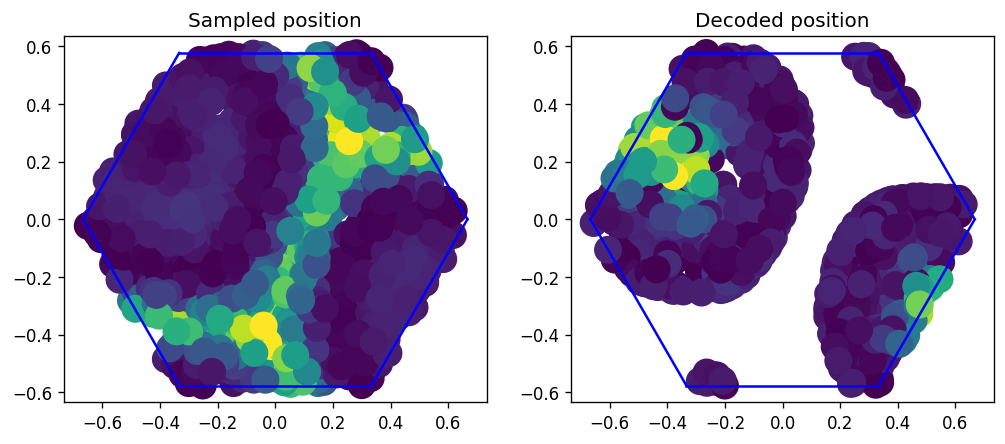

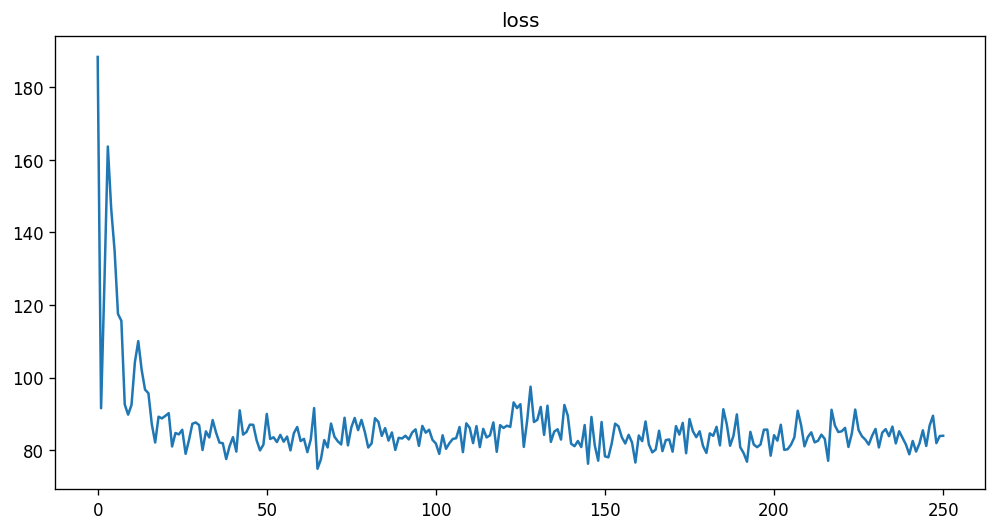

In [9]:
least_squares = False
hex_metric = True
for i, num_pos in enumerate(num_pos_all):
    for j, N in enumerate(N_all):
        print('Num pos', num_pos)
        print('Num neurons', N)
        print('')
        model = LinDecoder(N = N,
                           num_pos = num_pos,
                           hex_metric = hex_metric,
                           least_squares = least_squares,
                    )
        model.train()
        bestphase = np.argmin(model.stats['loss'])
        all_loss[i,j] = model.stats['loss'][bestphase]
        if bVerbose:
            plot_results(model)
            


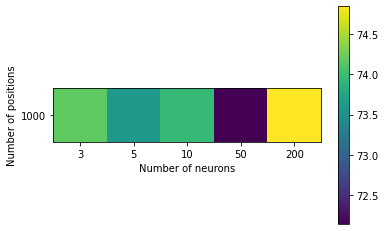

In [10]:
plt.imshow(all_loss)#, origin = 'lower')
plt.yticks(np.arange(len(num_pos_all)), np.array(num_pos_all,dtype = str))
plt.xticks(np.arange(len(N_all)), np.array(N_all,dtype = str))
plt.xlabel('Number of neurons')
plt.ylabel('Number of positions')
plt.colorbar()